<a href="https://colab.research.google.com/github/Jane0731/Homework/blob/main/VAE_Diffusion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Áπ™Âúñ‰∏≠ÊñáË®≠ÂÆö

In [ ]:
# Colab ÈÄ≤Ë°åmatplotlibÁπ™ÂúñÊôÇÈ°ØÁ§∫ÁπÅÈ´î‰∏≠Êñá
# ‰∏ãËºâÂè∞ÂåóÊÄùÊ∫êÈªëÈ´î‰∏¶ÂëΩÂêçtaipei_sans_tc_beta.ttfÔºåÁßªËá≥ÊåáÂÆöË∑ØÂæë
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

# ÊîπstyleË¶ÅÂú®Êîπfont‰πãÂâç
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

print(" Áí∞Â¢ÉË®≠ÁΩÆÂÆåÊàêÔºÅ")

--2025-10-02 03:54:44--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 172.253.118.113, 172.253.118.100, 172.253.118.138, ...
Connecting to drive.google.com (drive.google.com)|172.253.118.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-10-02 03:54:44--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.10.132, 2404:6800:4003:c0f::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.10.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‚ÄòTaipeiSansTCBeta-Regular.ttf‚Äô

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  29.1MB/s    in 0.7s    

2025-10-0

#ÂõõÁ®ÆÊ®°Âûã

##VAE

### Ê®°ÂûãË®≠ÂÆö


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time

class VAE(nn.Module):
    """
    Variational Autoencoder for MNIST
    ÊåâÁÖßË¶ÅÊ±ÇÔºöÂ∞ÜËæìÂÖ•ÂõæÂÉèÂ±ïÂπ≥ÔºåÂéãÁº©Âà∞ÊΩúÂú®Á©∫Èó¥(z)ÔºåËæìÂá∫ÂùáÂÄºŒº‰∏éÂØπÊï∞ÊñπÂ∑Ælog œÉ¬≤
    """
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        self.input_dim = input_dim  # 28*28 = 784
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim  # ÊΩúÂú®Á©∫Èó¥Áª¥Â∫¶

        # Encoder: Â∞ÜËæìÂÖ•ÂõæÂÉèÁºñÁ†ÅÂà∞ÊΩúÂú®Á©∫Èó¥
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        # ÊΩúÂú®Á©∫Èó¥ÁöÑÂùáÂÄºÂíåÂØπÊï∞ÊñπÂ∑Æ
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)      # ÂùáÂÄº Œº
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)  # ÂØπÊï∞ÊñπÂ∑Æ log œÉ¬≤

        # Decoder: ‰ªéÊΩúÂú®Á©∫Èó¥zËøòÂéüÂõæÂÉè (28√ó28)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # ËæìÂá∫Âà∞[0,1]ËåÉÂõ¥
        )

    def encode(self, x):
        """ÁºñÁ†ÅÔºöËæìÂÖ•ÂõæÂÉè -> ÊΩúÂú®Á©∫Èó¥ÂèÇÊï∞ (Œº, log œÉ¬≤)"""
        # Â±ïÂπ≥ÂõæÂÉè
        x = x.view(x.size(0), -1)  # (batch_size, 784)

        # ÈÄöËøáÁºñÁ†ÅÂô®
        h = self.encoder(x)

        # ËæìÂá∫ÂùáÂÄºÂíåÂØπÊï∞ÊñπÂ∑Æ
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        """ÈáçÂèÇÊï∞ÂåñÊäÄÂ∑ßÔºö‰ªé N(Œº, œÉ¬≤) ÈááÊ†∑"""
        std = torch.exp(0.5 * logvar)  # œÉ = exp(0.5 * log œÉ¬≤)
        eps = torch.randn_like(std)    # ‰ªéÊ†áÂáÜÊ≠£ÊÄÅÂàÜÂ∏ÉÈááÊ†∑
        z = mu + eps * std             # z = Œº + Œµ * œÉ
        return z

    def decode(self, z):
        """Ëß£Á†ÅÔºöÊΩúÂú®ÂèòÈáèz -> ÈáçÊûÑÂõæÂÉè"""
        x_recon = self.decoder(z)
        return x_recon.view(x_recon.size(0), 1, 28, 28)  # ÈáçÂ°ë‰∏∫ÂõæÂÉèÊ†ºÂºè

    def forward(self, x):
        """VAEÂâçÂêë‰º†Êí≠"""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

    def sample(self, num_samples=10, device='cpu'):
        """‰ªéÊΩúÂú®Á©∫Èó¥ÈááÊ†∑ÁîüÊàêÊñ∞ÂõæÂÉè"""
        with torch.no_grad():
            # ‰ªéÊ†áÂáÜÊ≠£ÊÄÅÂàÜÂ∏ÉÈááÊ†∑
            z = torch.randn(num_samples, self.latent_dim).to(device)
            samples = self.decode(z)
        return samples


def vae_loss_function(recon_x, x, mu, logvar):
    """
    VAEÊçüÂ§±ÂáΩÊï∞ = ÈáçÂª∫ÊçüÂ§±(BCE) + KLÊï£Â∫¶ÊçüÂ§±
    """
    # ÈáçÂª∫ÊçüÂ§± (Binary Cross Entropy)
    BCE = F.binary_cross_entropy(
        recon_x.view(-1, 784),
        x.view(-1, 784),
        reduction='sum'
    )

    # KLÊï£Â∫¶ÊçüÂ§±: D_KL(q(z|x) || p(z))
    # ÂÖ∂‰∏≠ q(z|x) = N(Œº, œÉ¬≤), p(z) = N(0, I)
    # KLD = -0.5 * sum(1 + log œÉ¬≤ - Œº¬≤ - œÉ¬≤)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

### Ë≥áÊñôÈ†êËôïÁêÜÊî∂ÈõÜ

In [ ]:

def get_mnist_dataloaders(batch_size=128):
    """
    ËΩΩÂÖ•MNISTÊï∞ÊçÆÈõÜ - ÁÆÄÂåñÁâàÔºöËÆ≠ÁªÉÈõÜ + ÊµãËØïÈõÜ
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # ËÆ≠ÁªÉÈõÜ
    train_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        transform=transform,
        download=True
    )

    # ÊµãËØïÈõÜ
    test_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=False,
        transform=transform,
        download=True
    )

    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    test_dataloader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    print(f"Êï∞ÊçÆÈõÜ‰ø°ÊÅØ:")
    print(f"  ËÆ≠ÁªÉÈõÜ: {len(train_dataset)} Âº†ÂõæÁâá")
    print(f"  ÊµãËØïÈõÜ: {len(test_dataset)} Âº†ÂõæÁâá")

    return train_dataloader, test_dataloader


### Ë®ìÁ∑¥ÂíåÂèØË¶ñÂåñ

In [ ]:
def train_vae_model(model, train_dataloader, test_dataloader, epochs=30, lr=1e-3, device='cuda'):
    """
    Ë®ìÁ∑¥VAEÊ®°Âûã - ÂåÖÂê´Ë®ìÁ∑¥ÈõÜÂíåÊ∏¨Ë©¶ÈõÜË©ï‰º∞
    """
    # Ë®≠ÁΩÆË®ìÁ∑¥seed‰ª•Á¢∫‰øùÂèØÈáçÁèæÊÄß
    torch.manual_seed(42)
    if device == 'cuda':
        torch.cuda.manual_seed(42)
        torch.cuda.manual_seed_all(42)
    np.random.seed(42)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    # Ë®ìÁ∑¥Áõ£ÊéßÊåáÊ®ô
    training_metrics = {
        'train_losses': [],      # Ë®ìÁ∑¥ÊêçÂ§±
        'test_losses': [],       # Ê∏¨Ë©¶ÊêçÂ§±
        'train_bce_losses': [],  # Ë®ìÁ∑¥ÈáçÂª∫ÊêçÂ§±
        'train_kld_losses': [],  # Ë®ìÁ∑¥KLÊï£Â∫¶ÊêçÂ§±
        'batch_losses': [],
        'gradient_norms': [],
        'epoch_times': [],
        'total_training_time': 0
    }

    print("ÈñãÂßãË®ìÁ∑¥MNIST VAEÊ®°Âûã...")
    print(f"Ë®ìÁ∑¥ÈõÜÂ§ßÂ∞è: {len(train_dataloader.dataset)}")
    print(f"Ê∏¨Ë©¶ÈõÜÂ§ßÂ∞è: {len(test_dataloader.dataset)}")
    print(f"ÊâπÊ¨°Â§ßÂ∞è: {train_dataloader.batch_size}")
    print(f"Ë®ìÁ∑¥ÊâπÊ¨°Êï∏: {len(train_dataloader)}")
    print("=" * 60)

    total_start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()

        # ============ Ë®ìÁ∑¥ÈöéÊÆµ ============
        model.train()
        total_train_loss = 0
        total_train_bce = 0
        total_train_kld = 0
        num_batches = len(train_dataloader)
        epoch_gradient_norms = []

        for batch_idx, (data, _) in enumerate(train_dataloader):
            data = data.to(device)

            # ÂâçÂêëÂÇ≥Êí≠
            recon_batch, mu, logvar = model(data)

            # Ë®àÁÆóÊêçÂ§±
            loss, bce, kld = vae_loss_function(recon_batch, data, mu, logvar)

            # ÂèçÂêëÂÇ≥Êí≠
            optimizer.zero_grad()
            loss.backward()

            # Ë®àÁÆóÊ¢ØÂ∫¶ÁØÑÊï∏
            total_grad_norm = 0
            for param in model.parameters():
                if param.grad is not None:
                    param_grad_norm = param.grad.data.norm(2)
                    total_grad_norm += param_grad_norm.item() ** 2
            total_grad_norm = total_grad_norm ** (1. / 2)
            epoch_gradient_norms.append(total_grad_norm)

            optimizer.step()

            # Ë®òÈåÑÊêçÂ§±
            total_train_loss += loss.item()
            total_train_bce += bce.item()
            total_train_kld += kld.item()
            training_metrics['batch_losses'].append(loss.item())

            # ÊØè200ÂÄãÊâπÊ¨°‰∏îÊØè10ÂÄãepochÈ°ØÁ§∫ÈÄ≤Â∫¶
            if epoch % 10 == 0:
                if batch_idx % 200 == 0:
                    print(f'Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}/{num_batches}], '
                          f'Total Loss: {loss.item()/len(data):.4f}, BCE: {bce.item()/len(data):.4f}, '
                          f'KLD: {kld.item()/len(data):.4f}')

        # ============ Ê∏¨Ë©¶ÈöéÊÆµ ============
        model.eval()
        total_test_loss = 0
        test_batches = len(test_dataloader)

        with torch.no_grad():
            for data, _ in test_dataloader:
                data = data.to(device)
                recon_batch, mu, logvar = model(data)
                loss, _, _ = vae_loss_function(recon_batch, data, mu, logvar)
                total_test_loss += loss.item()

        # Ë®òÈåÑepochÊåáÊ®ô
        epoch_time = time.time() - epoch_start_time
        avg_train_loss = total_train_loss / len(train_dataloader.dataset)
        avg_test_loss = total_test_loss / len(test_dataloader.dataset)
        avg_train_bce = total_train_bce / len(train_dataloader.dataset)
        avg_train_kld = total_train_kld / len(train_dataloader.dataset)
        avg_grad_norm = sum(epoch_gradient_norms) / len(epoch_gradient_norms)

        training_metrics['train_losses'].append(avg_train_loss)
        training_metrics['test_losses'].append(avg_test_loss)
        training_metrics['train_bce_losses'].append(avg_train_bce)
        training_metrics['train_kld_losses'].append(avg_train_kld)
        training_metrics['gradient_norms'].append(avg_grad_norm)
        training_metrics['epoch_times'].append(epoch_time)

        print(f'Epoch [{epoch+1}/{epochs}] - Ë®ìÁ∑¥ÊêçÂ§±: {avg_train_loss:.4f}, '
              f'Ê∏¨Ë©¶ÊêçÂ§±: {avg_test_loss:.4f}, ÈáçÂª∫ÊêçÂ§±: {avg_train_bce:.4f}, '
              f'KLÊêçÂ§±: {avg_train_kld:.4f}, Ê¢ØÂ∫¶ÁØÑÊï∏: {avg_grad_norm:.4f}, '
              f'Áî®ÊôÇ: {epoch_time:.1f}Áßí')
        print("-" * 60)

    # Á∏ΩË®ìÁ∑¥ÊôÇÈñì
    total_training_time = time.time() - total_start_time
    training_metrics['total_training_time'] = total_training_time

    print("=" * 60)
    print("VAEË®ìÁ∑¥ÂÆåÊàêÔºÅ")
    print(f"Á∏ΩË®ìÁ∑¥ÊôÇÈñì: {total_training_time/60:.2f} ÂàÜÈêò")
    print(f"Âπ≥ÂùáÊØèepochÊôÇÈñì: {np.mean(training_metrics['epoch_times']):.1f} Áßí")
    print(f"ÊúÄÁµÇË®ìÁ∑¥ÊêçÂ§±: {training_metrics['train_losses'][-1]:.4f}")
    print(f"ÊúÄÁµÇÊ∏¨Ë©¶ÊêçÂ§±: {training_metrics['test_losses'][-1]:.4f}")
    print("=" * 60)

    return model, training_metrics


def generate_vae_images(model, num_images=10, device='cuda'):
    """
    Èö®Ê©üÁîüÊàêVAEÂúñÂÉè - ÁßªÈô§seedË®≠ÁΩÆÔºåÊØèÊ¨°ÁîüÊàêÈÉΩÊòØÈö®Ê©üÁöÑ
    """
    model.eval()

    # ÁßªÈô§ torch.manual_seed(42)ÔºåËÆìÁîüÊàêÈÅéÁ®ãÂÆåÂÖ®Èö®Ê©ü

    inference_start_time = time.time()
    print(f"Ê≠£Âú®ÁîüÊàê {num_images} ÂºµMNISTÂúñÂÉè...")
    generated_images = model.sample(num_images, device=device)
    inference_time = time.time() - inference_start_time

    print(f"VAEÁîüÊàêÂÆåÊàêÔºÅÊé®ÁêÜÊôÇÈñì: {inference_time:.4f} Áßí")
    print(f"Âπ≥ÂùáÊØèÂºµÂúñÁâá: {inference_time/num_images:.4f} Áßí")
    return generated_images, inference_time


def visualize_vae_images(images, title="Generated VAE MNIST Images", inference_time=None):
    """
    Ë¶ñË¶∫ÂåñVAEÁîüÊàêÁöÑMNISTÂúñÁâá - Â¢ûÂä†Êé®ÁêÜÊôÇÈñìÈ°ØÁ§∫
    """
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))

    # Ê®ôÈ°å‰∏≠Âä†ÂÖ•Êé®ÁêÜÊôÇÈñìË≥áË®ä
    if inference_time is not None:
        full_title = f"{title}\nÊé®ÁêÜÊôÇÈñì: {inference_time:.4f}Áßí, Âπ≥ÂùáÊØèÂºµ: {inference_time/len(images):.4f}Áßí"
    else:
        full_title = title

    fig.suptitle(full_title, fontsize=14)

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            img = images[i].squeeze().cpu().numpy()
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            ax.set_title(f'Image {i+1}', fontsize=10)
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()


def plot_vae_training_metrics(training_metrics):
    """
    Áπ™Ë£ΩVAEË®ìÁ∑¥ÊåáÊ®ô - ÂåÖÂê´Ë®ìÁ∑¥ÊêçÂ§±ÂíåÊ∏¨Ë©¶ÊêçÂ§±Â∞çÊØî
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('VAE Ë®ìÁ∑¥ÊåáÊ®ôÂàÜÊûê', fontsize=16)

    epochs = range(1, len(training_metrics['train_losses'])+1)

    # 1. Ë®ìÁ∑¥ÊêçÂ§± vs Ê∏¨Ë©¶ÊêçÂ§±
    axes[0, 0].plot(epochs, training_metrics['train_losses'], 'b-',
                    linewidth=2, label='Ë®ìÁ∑¥ÈõÜÁ∏ΩÊêçÂ§±', marker='o', markersize=3)
    axes[0, 0].plot(epochs, training_metrics['test_losses'], 'r-',
                    linewidth=2, label='Ê∏¨Ë©¶ÈõÜÁ∏ΩÊêçÂ§±', marker='s', markersize=3)
    axes[0, 0].plot(epochs, training_metrics['train_bce_losses'], 'g--',
                    linewidth=1, label='Ë®ìÁ∑¥ÈáçÂª∫ÊêçÂ§±(BCE)', alpha=0.7)
    axes[0, 0].plot(epochs, training_metrics['train_kld_losses'], 'm--',
                    linewidth=1, label='Ë®ìÁ∑¥KLÊï£Â∫¶ÊêçÂ§±', alpha=0.7)
    axes[0, 0].set_title('VAEÊêçÂ§±ÁµÑ‰ª∂ÂàÜÊûê')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend(loc='upper right', fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Ê≥õÂåñÂàÜÊûê (Ë®ìÁ∑¥ÊêçÂ§± - Ê∏¨Ë©¶ÊêçÂ§±)
    generalization_gap = [t - test for t, test in zip(training_metrics['train_losses'],
                                                     training_metrics['test_losses'])]
    axes[0, 1].plot(epochs, generalization_gap, 'purple', linewidth=2)
    axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[0, 1].fill_between(epochs, generalization_gap, 0, where=[g > 0 for g in generalization_gap],
                           alpha=0.3, color='red', label='Ë®ìÁ∑¥ > Ê∏¨Ë©¶ (ÈÅéÊì¨ÂêàÈ¢®Èö™)')
    axes[0, 1].fill_between(epochs, generalization_gap, 0, where=[g <= 0 for g in generalization_gap],
                           alpha=0.3, color='green', label='Ê∏¨Ë©¶ ‚â§ Ë®ìÁ∑¥ (ËâØÂ•ΩÊ≥õÂåñ)')
    axes[0, 1].set_title('Ê≥õÂåñËÉΩÂäõÂàÜÊûê (Ë®ìÁ∑¥ÊêçÂ§± - Ê∏¨Ë©¶ÊêçÂ§±)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('ÊêçÂ§±Â∑ÆÂÄº')
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)

    # Ê∑ªÂä†Ëß£ÈáãÊñáÂ≠ó
    axes[0, 1].text(0.02, 0.95, '> 0: Ë®ìÁ∑¥ÊêçÂ§±È´òÊñºÊ∏¨Ë©¶ÊêçÂ§±\n< 0: Ê∏¨Ë©¶ÊêçÂ§±È´òÊñºË®ìÁ∑¥ÊêçÂ§±',
                   transform=axes[0, 1].transAxes, fontsize=9,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8),
                   verticalalignment='top')

    # 3. ÊØèÂÄãepochË®ìÁ∑¥ÊôÇÈñì
    axes[1, 0].bar(epochs, training_metrics['epoch_times'], alpha=0.7, color='green')
    axes[1, 0].set_title('ÊØèÂÄãEpochË®ìÁ∑¥ÊôÇÈñì')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('ÊôÇÈñì (Áßí)')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Ê¢ØÂ∫¶ÁØÑÊï∏ËÆäÂåñ
    axes[1, 1].plot(epochs, training_metrics['gradient_norms'], 'orange', linewidth=2)
    axes[1, 1].set_title('Ê¢ØÂ∫¶ÁØÑÊï∏ËÆäÂåñ')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Gradient Norm')
    axes[1, 1].grid(True, alpha=0.3)

    # Ê∑ªÂä†Á∏ΩÁµêË≥áË®ä
    final_train_loss = training_metrics['train_losses'][-1]
    final_test_loss = training_metrics['test_losses'][-1]
    total_time_text = (f"Á∏ΩË®ìÁ∑¥ÊôÇÈñì: {training_metrics['total_training_time']/60:.2f} ÂàÜÈêò | "
                      f"ÊúÄÁµÇË®ìÁ∑¥ÊêçÂ§±: {final_train_loss:.4f} | ÊúÄÁµÇÊ∏¨Ë©¶ÊêçÂ§±: {final_test_loss:.4f}")
    fig.text(0.5, 0.02, total_time_text, ha='center', fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()


def test_vae_performance(model, test_dataloader, device='cuda'):
    """
    Âú®Ê∏¨Ë©¶ÈõÜ‰∏äË©ï‰º∞VAEÊ®°ÂûãÊÄßËÉΩ
    """
    model.eval()
    total_test_loss = 0
    num_batches = len(test_dataloader)

    print("Âú®Ê∏¨Ë©¶ÈõÜ‰∏äË©ï‰º∞VAEÊ®°Âûã...")

    with torch.no_grad():
        for data, _ in test_dataloader:
            data = data.to(device)

            # ÂâçÂêëÂÇ≥Êí≠
            recon_batch, mu, logvar = model(data)

            # Ë®àÁÆóÊêçÂ§±
            loss, _, _ = vae_loss_function(recon_batch, data, mu, logvar)
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_dataloader.dataset)
    print(f"Ê∏¨Ë©¶ÈõÜÂπ≥ÂùáÊêçÂ§±: {avg_test_loss:.4f}")
    return avg_test_loss

### ‰∏ªÁ®ãÂºèÂíåÁµêÊûú

‰ΩøÁî®ËÆæÂ§á: cuda
ËºâÂÖ•MNISTË≥áÊñô...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 9.91M/9.91M [00:02<00:00, 4.45MB/s]
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4.54k/4.54k [00:00<00:00, 8.04MB/s]


Êï∞ÊçÆÈõÜ‰ø°ÊÅØ:
  ËÆ≠ÁªÉÈõÜ: 60000 Âº†ÂõæÁâá
  ÊµãËØïÈõÜ: 10000 Âº†ÂõæÁâá
ÂâµÂª∫VAEÊ®°Âûã...
VAEÂèÉÊï∏Èáè: 973,624
Ë®ìÁ∑¥VAE...
ÈñãÂßãË®ìÁ∑¥MNIST VAEÊ®°Âûã...
Ë®ìÁ∑¥ÈõÜÂ§ßÂ∞è: 60000
Ê∏¨Ë©¶ÈõÜÂ§ßÂ∞è: 10000
ÊâπÊ¨°Â§ßÂ∞è: 128
Ë®ìÁ∑¥ÊâπÊ¨°Êï∏: 469
Epoch [1/30], Batch [0/469], Total Loss: 544.7667, BCE: 544.7385, KLD: 0.0282
Epoch [1/30], Batch [200/469], Total Loss: 175.5259, BCE: 168.4435, KLD: 7.0824
Epoch [1/30], Batch [400/469], Total Loss: 139.8943, BCE: 127.0510, KLD: 12.8433
Epoch [1/30] - Ë®ìÁ∑¥ÊêçÂ§±: 175.9769, Ê∏¨Ë©¶ÊêçÂ§±: 134.9234, ÈáçÂª∫ÊêçÂ§±: 168.3888, KLÊêçÂ§±: 7.5881, Ê¢ØÂ∫¶ÁØÑÊï∏: 4619.5021, Áî®ÊôÇ: 9.9Áßí
------------------------------------------------------------
Epoch [2/30] - Ë®ìÁ∑¥ÊêçÂ§±: 127.6079, Ê∏¨Ë©¶ÊêçÂ§±: 120.5887, ÈáçÂª∫ÊêçÂ§±: 113.2216, KLÊêçÂ§±: 14.3863, Ê¢ØÂ∫¶ÁØÑÊï∏: 6505.4800, Áî®ÊôÇ: 8.4Áßí
------------------------------------------------------------
Epoch [3/30] - Ë®ìÁ∑¥ÊêçÂ§±: 117.9427, Ê∏¨Ë©¶ÊêçÂ§±: 114.3016, ÈáçÂª∫ÊêçÂ§±: 101.7624, KLÊêçÂ§±: 16.180

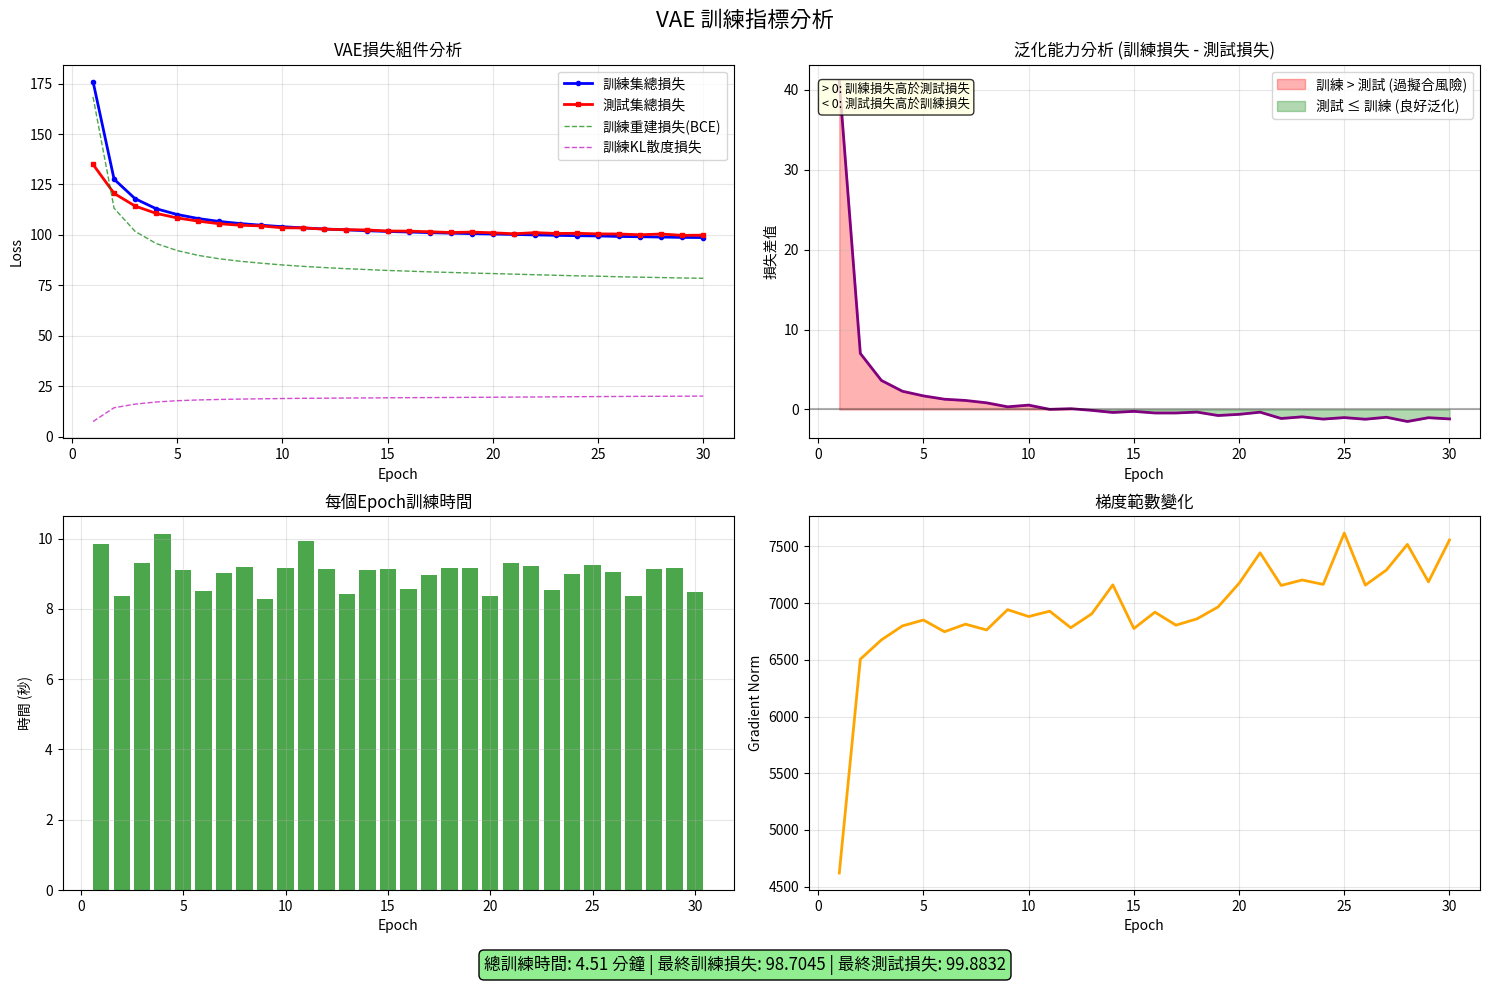

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"‰ΩøÁî®ËÆæÂ§á: {device}")

batch_size = 128  # ÊåâÁÖßË¶ÅÊ±Ç

# 1. ËºâÂÖ•MNISTË≥áÊñô
print("ËºâÂÖ•MNISTË≥áÊñô...")
train_dataloader,test_dataloader = get_mnist_dataloaders(batch_size=batch_size)

# 2. ÂâµÂª∫VAEÊ®°Âûã
print("ÂâµÂª∫VAEÊ®°Âûã...")
vae_model = VAE(input_dim=784, hidden_dim=400, latent_dim=20)
print(f"VAEÂèÉÊï∏Èáè: {sum(p.numel() for p in vae_model.parameters()):,}")

# 3. Ë®ìÁ∑¥VAEÊ®°Âûã
print("Ë®ìÁ∑¥VAE...")
trained_vae_model, vae_training_metrics = train_vae_model(
    vae_model,
    train_dataloader,
    test_dataloader,
    epochs=30,  # ÂèØË∞ÉÊï¥
    lr=1e-3,    # ÊåâÁÖßË¶ÅÊ±Ç
    device=device
)

# 4. Ë®ìÁ∑¥ÊåáÊ®ô
plot_vae_training_metrics(vae_training_metrics)

ÁîüÊàêVAEÂõæÂÉè...
Ê≠£Âú®ÁîüÊàê 10 ÂºµMNISTÂúñÂÉè...
VAEÁîüÊàêÂÆåÊàêÔºÅÊé®ÁêÜÊôÇÈñì: 0.0037 Áßí
Âπ≥ÂùáÊØèÂºµÂúñÁâá: 0.0004 Áßí


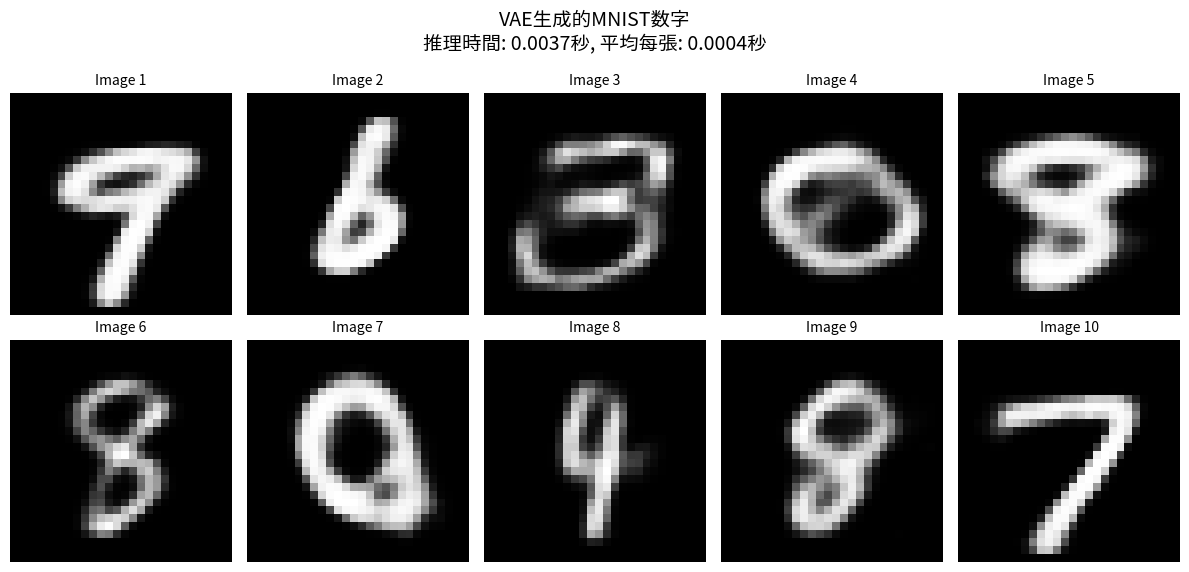

VAEÊ®°ÂûãÂ∑≤‰øùÂ≠ò‰∏∫ 'mnist_vae_model.pth'


In [ ]:
# 5. ÁîüÊàê10Âº†MNISTÂõæÂÉè
print("ÁîüÊàêVAEÂõæÂÉè...")
vae_generated_images, vae_inference_time = generate_vae_images(
    trained_vae_model, num_images=10, device=device
)

# 6. ÂèØËßÜÂåñÁªìÊûú
visualize_vae_images(vae_generated_images, "VAEÁîüÊàêÁöÑMNISTÊï∞Â≠ó", vae_inference_time)

# 7. ‰øùÂ≠òÊ®°ÂûãÂíåËÆ≠ÁªÉÊåáÊ†á
torch.save(trained_vae_model.state_dict(), 'mnist_vae_model.pth')
print("VAEÊ®°ÂûãÂ∑≤‰øùÂ≠ò‰∏∫ 'mnist_vae_model.pth'")

##Diffusion model

###Ê®°ÂûãË®≠ÂÆö

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import math
import matplotlib.pyplot as plt
from typing import Tuple, Optional
import warnings
import time

warnings.filterwarnings("ignore")
class DiffusionModel(nn.Module):
    def __init__(self, img_channels=1, img_size=28, timesteps=1000):
        super().__init__()
        self.img_channels = img_channels  # MNISTÁÇ∫1ÈÄöÈÅì(ÁÅ∞Èöé)
        self.img_size = img_size  # MNISTÁÇ∫28x28
        self.timesteps = timesteps

        # Âª∫Á´ãÂô™ËÅ≤Ë™øÂ∫¶
        self.beta_start = 0.0001
        self.beta_end = 0.02
        self.betas = self._cosine_beta_schedule()
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)

        # Ë®àÁÆóÂâçÂêëÈÅéÁ®ãÊâÄÈúÄÁöÑÂ∏∏Êï∏
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)

        # Ë®àÁÆóÂæåÂêëÈÅéÁ®ãÊâÄÈúÄÁöÑÂ∏∏Êï∏
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)

        # U-Net ÂéªÂô™Á∂≤Ë∑Ø (ÈÅ©ÈÖçMNIST)
        self.unet = UNet(img_channels, timesteps)

    def _cosine_beta_schedule(self):
        """È§òÂº¶Ë™øÂ∫¶Âô® - Êõ¥Á©©ÂÆöÁöÑÂô™ËÅ≤Ë™øÂ∫¶"""
        steps = self.timesteps + 1
        x = torch.linspace(0, self.timesteps, steps)
        alphas_cumprod = torch.cos(((x / self.timesteps) + 0.008) / 1.008 * math.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0, 0.999)

    def forward_diffusion_sample(self, x_0: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        ÂâçÂêëÈÅéÁ®ãÔºöÈÄêÊ≠•Â∞áÂô™ËÅ≤Âä†Âà∞ÂúñÁâá‰∏ä
        x_0: ÂéüÂßãMNISTÂúñÁâá (batch_size, 1, 28, 28)
        t: ÊôÇÈñìÊ≠•
        ËøîÂõû: (Âä†Âô™ÂæåÁöÑÂúñÁâá, Ê∑ªÂä†ÁöÑÂô™ËÅ≤)
        """
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self._get_index_from_list(self.sqrt_alphas_cumprod, t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self._get_index_from_list(self.sqrt_one_minus_alphas_cumprod, t, x_0.shape)

        # q(x_t | x_0) = N(sqrt(alpha_cumprod_t) * x_0, (1 - alpha_cumprod_t) * I)
        x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
        return x_t, noise

    def _get_index_from_list(self, vals, t, x_shape):
        """ÂæûÈ†êË®àÁÆóÁöÑÂÄº‰∏≠ÂèñÂá∫Â∞çÊáâÊôÇÈñìÊ≠•ÁöÑÂÄº"""
        batch_size = t.shape[0]
        out = vals.gather(-1, t.cpu())
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

    def forward(self, x_0: torch.Tensor) -> torch.Tensor:
        """
        Ë®ìÁ∑¥ÊôÇÁöÑÂâçÂêëÂÇ≥Êí≠
        """
        device = x_0.device
        batch_size = x_0.shape[0]

        # Èö®Ê©üÈÅ∏ÊìáÊôÇÈñìÊ≠•
        t = torch.randint(0, self.timesteps, (batch_size,), device=device).long()

        # ÂâçÂêëÊì¥Êï£
        x_t, noise = self.forward_diffusion_sample(x_0, t)

        # ‰ΩøÁî®U-NetÈ†êÊ∏¨Âô™ËÅ≤
        predicted_noise = self.unet(x_t, t)

        return predicted_noise, noise

    @torch.no_grad()
    def sample_timestep(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        ÈÄÜÂêëÈÅéÁ®ãÁöÑÂñÆÊ≠•Êé°Ê®£
        """
        betas_t = self._get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self._get_index_from_list(self.sqrt_one_minus_alphas_cumprod, t, x.shape)
        sqrt_recip_alphas_t = self._get_index_from_list(self.sqrt_recip_alphas, t, x.shape)

        # ‰ΩøÁî®U-NetÈ†êÊ∏¨Âô™ËÅ≤
        predicted_noise = self.unet(x, t)

        # Ë®àÁÆóÂùáÂÄº
        model_mean = sqrt_recip_alphas_t * (x - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t)

        if t[0] == 0:
            return model_mean
        else:
            posterior_variance_t = self._get_index_from_list(self.posterior_variance, t, x.shape)
            noise = torch.randn_like(x)
            return model_mean + torch.sqrt(posterior_variance_t) * noise

    @torch.no_grad()
    def sample(self, num_samples: int, device: str = 'cpu') -> torch.Tensor:
        """
        ÈÄÜÂêëÈÅéÁ®ãÔºöÂæûÂô™ËÅ≤ÁîüÊàêMNISTÊï∏Â≠óÂúñÁâá
        """
        # ÂæûÁ¥îÂô™ËÅ≤ÈñãÂßã (MNIST: 1ÈÄöÈÅì, 28x28)
        x = torch.randn((num_samples, self.img_channels, self.img_size, self.img_size), device=device)

        # ÈÄÜÂêëÊì¥Êï£
        for i in reversed(range(0, self.timesteps)):
            t = torch.full((num_samples,), i, device=device, dtype=torch.long)
            x = self.sample_timestep(x, t)

        return x


class UNet(nn.Module):
    """U-NetÂéªÂô™Á∂≤Ë∑Ø - ÈÅ©ÈÖçMNIST (28x28, ÂñÆÈÄöÈÅì)"""
    def __init__(self, img_channels=1, time_dim=1000):
        super().__init__()
        self.time_dim = time_dim

        # ÊôÇÈñìÂµåÂÖ•
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.ReLU()
        )

        # ‰∏ãÊé°Ê®£Ë∑ØÂæë (ÈÅ©ÈÖç28x28Ëº∏ÂÖ•)
        self.downs = nn.ModuleList([
            Block(img_channels, 32, time_dim),  # 28x28 -> 14x14
            Block(32, 64, time_dim),            # 14x14 -> 7x7
            Block(64, 128, time_dim),           # 7x7 -> 3x3 (Âêë‰∏ãÂèñÊï¥)
        ])

        # Áì∂È†∏Â±§
        self.bottleneck = Block(128, 256, time_dim)

        # ‰∏äÊé°Ê®£Ë∑ØÂæë
        self.ups = nn.ModuleList([
            Block(256 + 128, 128, time_dim),   # 3x3 -> 7x7
            Block(128 + 64, 64, time_dim),     # 7x7 -> 14x14
            Block(64 + 32, 32, time_dim),      # 14x14 -> 28x28
        ])

        # Ëº∏Âá∫Â±§
        self.output = nn.Conv2d(32, img_channels, 1)

    def forward(self, x, t):
        # ÊôÇÈñìÂµåÂÖ•
        t = self.time_mlp(t)

        # ‰∏ãÊé°Ê®£
        residuals = []
        for down in self.downs:
            x = down(x, t)
            residuals.append(x)
            x = F.max_pool2d(x, 2)

        # Áì∂È†∏
        x = self.bottleneck(x, t)

        # ‰∏äÊé°Ê®£
        for up in self.ups:
            x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
            residual_x = residuals.pop()
            # Á¢∫‰øùÁ∂≠Â∫¶ÂåπÈÖç
            if x.shape != residual_x.shape:
                x = F.interpolate(x, size=residual_x.shape[2:], mode='bilinear', align_corners=True)
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)

        return self.output(x)


class Block(nn.Module):
    """U-NetÁöÑÂü∫Êú¨Â°ä"""
    def __init__(self, in_ch, out_ch, time_dim):
        super().__init__()
        self.time_mlp = nn.Linear(time_dim, out_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.norm1 = nn.GroupNorm(min(8, out_ch), out_ch)  # ÈÅ©ÈÖçËºÉÂ∞èÁöÑÈÄöÈÅìÊï∏
        self.norm2 = nn.GroupNorm(min(8, out_ch), out_ch)

    def forward(self, x, t):
        h = self.conv1(x)
        h = self.norm1(h)
        h = F.relu(h)

        # Âä†ÂÖ•ÊôÇÈñìÂµåÂÖ•
        time_emb = self.time_mlp(t)
        time_emb = time_emb[(..., ) + (None, ) * 2]  # Êì¥Â±ïÁ∂≠Â∫¶‰ª•ÂåπÈÖçÁâπÂæµÂúñ
        h = h + time_emb

        h = self.conv2(h)
        h = self.norm2(h)
        h = F.relu(h)

        return h


class SinusoidalPositionEmbeddings(nn.Module):
    """Ê≠£Âº¶‰ΩçÁΩÆÂµåÂÖ•Áî®ÊñºÊôÇÈñìÊ≠•"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


###Ë≥áÊñôÈ†êËôïÁêÜÂíåÊî∂ÈõÜ

In [ ]:
def get_mnist_dataloaders(batch_size=128):
    """
    ËΩΩÂÖ•MNISTÊï∞ÊçÆÈõÜ - ÁÆÄÂåñÁâàÔºöËÆ≠ÁªÉÈõÜ + ÊµãËØïÈõÜ
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # ÂΩí‰∏ÄÂåñÂà∞[-1, 1]
    ])

    # ËÆ≠ÁªÉÈõÜ
    train_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        transform=transform,
        download=True
    )

    # ÊµãËØïÈõÜ
    test_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=False,
        transform=transform,
        download=True
    )

    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    test_dataloader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    print(f"Êï∞ÊçÆÈõÜ‰ø°ÊÅØ:")
    print(f"  ËÆ≠ÁªÉÈõÜ: {len(train_dataset)} Âº†ÂõæÁâá")
    print(f"  ÊµãËØïÈõÜ: {len(test_dataset)} Âº†ÂõæÁâá")

    return train_dataloader, test_dataloader




###Ë®ìÁ∑¥ÂíåÂèØË¶ñÂåñ

In [ ]:
def test_model_performance(model, test_dataloader, device='cuda'):
    """
    Âú®Ê∏¨Ë©¶ÈõÜ‰∏äË©ï‰º∞Ê®°ÂûãÊÄßËÉΩ
    """
    model.eval()
    total_test_loss = 0
    num_batches = len(test_dataloader)
    mse_loss = nn.MSELoss()

    print("Âú®Ê∏¨Ë©¶ÈõÜ‰∏äË©ï‰º∞Ê®°Âûã...")

    with torch.no_grad():
        for data, _ in test_dataloader:
            data = data.to(device)

            # ÂâçÂêëÂÇ≥Êí≠
            predicted_noise, true_noise = model(data)

            # Ë®àÁÆóÊêçÂ§±
            loss = mse_loss(predicted_noise, true_noise)
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / num_batches
    print(f"Ê∏¨Ë©¶ÈõÜÂπ≥ÂùáÊêçÂ§±: {avg_test_loss:.4f}")
    return avg_test_loss


def train_diffusion_model(model, train_dataloader, test_dataloader, epochs=30, lr=1e-3, device='cuda'):
    """
    Ë®ìÁ∑¥ÂáΩÊï∏ - ÂåÖÂê´Ë®ìÁ∑¥ÈõÜÂíåÊ∏¨Ë©¶ÈõÜË©ï‰º∞
    """
    # Ë®≠ÁΩÆË®ìÁ∑¥seed
    torch.manual_seed(42)
    if device == 'cuda':
        torch.cuda.manual_seed(42)
        torch.cuda.manual_seed_all(42)
    np.random.seed(42)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()
    model.to(device)

    # Ë®ìÁ∑¥Áõ£ÊéßÊåáÊ®ô
    training_metrics = {
        'train_losses': [],      # Ë®ìÁ∑¥ÊêçÂ§±
        'test_losses': [],       # Ê∏¨Ë©¶ÊêçÂ§±
        'batch_losses': [],
        'gradient_norms': [],
        'epoch_times': [],
        'total_training_time': 0
    }

    print("ÈñãÂßãË®ìÁ∑¥MNIST Diffusion Model...")
    print(f"Ë®ìÁ∑¥ÈõÜÂ§ßÂ∞è: {len(train_dataloader.dataset)}")
    print(f"Ê∏¨Ë©¶ÈõÜÂ§ßÂ∞è: {len(test_dataloader.dataset)}")
    print(f"ÊâπÊ¨°Â§ßÂ∞è: {train_dataloader.batch_size}")
    print(f"Ë®ìÁ∑¥ÊâπÊ¨°Êï∏: {len(train_dataloader)}")
    print("=" * 60)

    total_start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()

        # ============ Ë®ìÁ∑¥ÈöéÊÆµ ============
        model.train()
        total_train_loss = 0
        num_batches = len(train_dataloader)
        epoch_gradient_norms = []

        for batch_idx, (data, labels) in enumerate(train_dataloader):
            data = data.to(device)

            # ÂâçÂêëÂÇ≥Êí≠
            predicted_noise, true_noise = model(data)

            # MSEÂéªÂô™ÊêçÂ§±
            loss = mse_loss(predicted_noise, true_noise)

            # ÂèçÂêëÂÇ≥Êí≠
            optimizer.zero_grad()
            loss.backward()

            # Ë®àÁÆóÊ¢ØÂ∫¶ÁØÑÊï∏
            total_grad_norm = 0
            for param in model.parameters():
                if param.grad is not None:
                    param_grad_norm = param.grad.data.norm(2)
                    total_grad_norm += param_grad_norm.item() ** 2
            total_grad_norm = total_grad_norm ** (1. / 2)
            epoch_gradient_norms.append(total_grad_norm)

            optimizer.step()

            total_train_loss += loss.item()
            training_metrics['batch_losses'].append(loss.item())

            # ÊØè200ÂÄãÊâπÊ¨°‰∏îÊØè10ÂÄãepochÈ°ØÁ§∫ÈÄ≤Â∫¶
            if epoch % 10 == 0:
                if batch_idx % 200 == 0:
                    print(f'Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}/{num_batches}], '
                          f'Train Loss: {loss.item():.4f}, Grad Norm: {total_grad_norm:.4f}')

        # ============ Ê∏¨Ë©¶ÈöéÊÆµ ============
        model.eval()
        total_test_loss = 0
        test_batches = len(test_dataloader)

        with torch.no_grad():
            for data, _ in test_dataloader:
                data = data.to(device)
                predicted_noise, true_noise = model(data)
                loss = mse_loss(predicted_noise, true_noise)
                total_test_loss += loss.item()

        # Ë®òÈåÑepochÊåáÊ®ô
        epoch_time = time.time() - epoch_start_time
        avg_train_loss = total_train_loss / num_batches
        avg_test_loss = total_test_loss / test_batches
        avg_grad_norm = sum(epoch_gradient_norms) / len(epoch_gradient_norms)

        training_metrics['train_losses'].append(avg_train_loss)
        training_metrics['test_losses'].append(avg_test_loss)
        training_metrics['gradient_norms'].append(avg_grad_norm)
        training_metrics['epoch_times'].append(epoch_time)

        print(f'Epoch [{epoch+1}/{epochs}] - Ë®ìÁ∑¥ÊêçÂ§±: {avg_train_loss:.4f}, '
              f'Ê∏¨Ë©¶ÊêçÂ§±: {avg_test_loss:.4f}, Ê¢ØÂ∫¶ÁØÑÊï∏: {avg_grad_norm:.4f}, '
              f'Áî®ÊôÇ: {epoch_time:.1f}Áßí')
        print("-" * 60)

    # Á∏ΩË®ìÁ∑¥ÊôÇÈñì
    total_training_time = time.time() - total_start_time
    training_metrics['total_training_time'] = total_training_time

    print("=" * 60)
    print("Ë®ìÁ∑¥ÂÆåÊàêÔºÅ")
    print(f"Á∏ΩË®ìÁ∑¥ÊôÇÈñì: {total_training_time/60:.2f} ÂàÜÈêò")
    print(f"Âπ≥ÂùáÊØèepochÊôÇÈñì: {np.mean(training_metrics['epoch_times']):.1f} Áßí")
    print(f"ÊúÄÁµÇË®ìÁ∑¥ÊêçÂ§±: {training_metrics['train_losses'][-1]:.4f}")
    print(f"ÊúÄÁµÇÊ∏¨Ë©¶ÊêçÂ§±: {training_metrics['test_losses'][-1]:.4f}")
    print("=" * 60)

    return model, training_metrics


def plot_training_metrics(training_metrics):
    """
    Áπ™Ë£ΩË®ìÁ∑¥ÊåáÊ®ô - ÂåÖÂê´Ë®ìÁ∑¥ÊêçÂ§±ÂíåÊ∏¨Ë©¶ÊêçÂ§±Â∞çÊØî
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Diffusion Model Ë®ìÁ∑¥ÊåáÊ®ôÂàÜÊûê', fontsize=16)

    epochs = range(1, len(training_metrics['train_losses'])+1)

    # 1. Ë®ìÁ∑¥ÊêçÂ§± vs Ê∏¨Ë©¶ÊêçÂ§±
    axes[0, 0].plot(epochs, training_metrics['train_losses'], 'b-',
                    linewidth=2, label='Ë®ìÁ∑¥ÈõÜÊêçÂ§±', marker='o', markersize=3)
    axes[0, 0].plot(epochs, training_metrics['test_losses'], 'r-',
                    linewidth=2, label='Ê∏¨Ë©¶ÈõÜÊêçÂ§±', marker='s', markersize=3)
    axes[0, 0].set_title('Ë®ìÁ∑¥ÊêçÂ§± vs Ê∏¨Ë©¶ÊêçÂ§±')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('MSE Loss')
    axes[0, 0].legend(loc='upper right')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Ê≥õÂåñÂàÜÊûê (Ë®ìÁ∑¥ÊêçÂ§± - Ê∏¨Ë©¶ÊêçÂ§±)
    generalization_gap = [t - test for t, test in zip(training_metrics['train_losses'],
                                                     training_metrics['test_losses'])]
    axes[0, 1].plot(epochs, generalization_gap, 'purple', linewidth=2)
    axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[0, 1].fill_between(epochs, generalization_gap, 0, where=[g > 0 for g in generalization_gap],
                           alpha=0.3, color='red', label='Ë®ìÁ∑¥ > Ê∏¨Ë©¶ (ÈÅéÊì¨ÂêàÈ¢®Èö™)')
    axes[0, 1].fill_between(epochs, generalization_gap, 0, where=[g <= 0 for g in generalization_gap],
                           alpha=0.3, color='green', label='Ê∏¨Ë©¶ ‚â§ Ë®ìÁ∑¥ (ËâØÂ•ΩÊ≥õÂåñ)')
    axes[0, 1].set_title('Ê≥õÂåñËÉΩÂäõÂàÜÊûê (Ë®ìÁ∑¥ÊêçÂ§± - Ê∏¨Ë©¶ÊêçÂ§±)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('ÊêçÂ§±Â∑ÆÂÄº')
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)

    # Ê∑ªÂä†Ëß£ÈáãÊñáÂ≠ó
    axes[0, 1].text(0.02, 0.95, '> 0: Ë®ìÁ∑¥ÊêçÂ§±È´òÊñºÊ∏¨Ë©¶ÊêçÂ§±\n< 0: Ê∏¨Ë©¶ÊêçÂ§±È´òÊñºË®ìÁ∑¥ÊêçÂ§±',
                   transform=axes[0, 1].transAxes, fontsize=9,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8),
                   verticalalignment='top')

    # 3. ÊØèÂÄãepochË®ìÁ∑¥ÊôÇÈñì
    axes[1, 0].bar(epochs, training_metrics['epoch_times'], alpha=0.7, color='green')
    axes[1, 0].set_title('ÊØèÂÄãEpochË®ìÁ∑¥ÊôÇÈñì')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('ÊôÇÈñì (Áßí)')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Ê¢ØÂ∫¶ÁØÑÊï∏ËÆäÂåñ
    axes[1, 1].plot(epochs, training_metrics['gradient_norms'], 'orange', linewidth=2)
    axes[1, 1].set_title('Ê¢ØÂ∫¶ÁØÑÊï∏ËÆäÂåñ')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Gradient Norm')
    axes[1, 1].grid(True, alpha=0.3)

    # Ê∑ªÂä†Á∏ΩÁµêË≥áË®ä
    final_train_loss = training_metrics['train_losses'][-1]
    final_test_loss = training_metrics['test_losses'][-1]
    total_time_text = (f"Á∏ΩË®ìÁ∑¥ÊôÇÈñì: {training_metrics['total_training_time']/60:.2f} ÂàÜÈêò | "
                      f"ÊúÄÁµÇË®ìÁ∑¥ÊêçÂ§±: {final_train_loss:.4f} | ÊúÄÁµÇÊ∏¨Ë©¶ÊêçÂ§±: {final_test_loss:.4f}")
    fig.text(0.5, 0.02, total_time_text, ha='center', fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()


def generate_mnist_images(model, num_images=10, device='cuda'):
    """
    Èö®Ê©üÁîüÊàêMNISTÊï∏Â≠óÂΩ±ÂÉè - ÁßªÈô§seedË®≠ÁΩÆ
    """
    model.eval()
    inference_start_time = time.time()

    with torch.no_grad():
        # ÁßªÈô§ torch.manual_seed(80)

        print(f"Ê≠£Âú®ÁîüÊàê {num_images} ÂºµMNISTÂΩ±ÂÉè...")
        generated_images = model.sample(num_images, device=device)
        generated_images = (generated_images + 1) / 2
        generated_images = torch.clamp(generated_images, 0, 1)

    inference_time = time.time() - inference_start_time
    print(f"ÁîüÊàêÂÆåÊàêÔºÅÊé®ÁêÜÊôÇÈñì: {inference_time:.2f} Áßí")
    print(f"Âπ≥ÂùáÊØèÂºµÂúñÁâá: {inference_time/num_images:.2f} Áßí")
    return generated_images, inference_time


def visualize_mnist_images(images, title="Generated MNIST Images", inference_time=None):
    """
    Ë¶ñË¶∫ÂåñÁîüÊàêÁöÑMNISTÂúñÁâá - Â¢ûÂä†Êé®ÁêÜÊôÇÈñìÈ°ØÁ§∫
    """
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))

    # Ê®ôÈ°å‰∏≠Âä†ÂÖ•Êé®ÁêÜÊôÇÈñìË≥áË®ä
    if inference_time is not None:
        full_title = f"{title}\nÊé®ÁêÜÊôÇÈñì: {inference_time:.2f}Áßí, Âπ≥ÂùáÊØèÂºµ: {inference_time/len(images):.2f}Áßí"
    else:
        full_title = title

    fig.suptitle(full_title, fontsize=14)

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            img = images[i].squeeze().cpu().numpy()
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            ax.set_title(f'Image {i+1}', fontsize=10)
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

###‰∏ªÁ®ãÂºèÂíåÁµêÊûú

‰ΩøÁî®Ë£ùÁΩÆ: cuda
ËºâÂÖ•MNISTË≥áÊñôÈõÜ...
Êï∞ÊçÆÈõÜ‰ø°ÊÅØ:
  ËÆ≠ÁªÉÈõÜ: 60000 Âº†ÂõæÁâá
  ÊµãËØïÈõÜ: 10000 Âº†ÂõæÁâá
Âª∫Á´ãDiffusion Model...
Ê®°ÂûãÂèÉÊï∏Èáè: 30,474,825
ÈñãÂßãË®ìÁ∑¥...
ÈñãÂßãË®ìÁ∑¥MNIST Diffusion Model...
Ë®ìÁ∑¥ÈõÜÂ§ßÂ∞è: 60000
Ê∏¨Ë©¶ÈõÜÂ§ßÂ∞è: 10000
ÊâπÊ¨°Â§ßÂ∞è: 128
Ë®ìÁ∑¥ÊâπÊ¨°Êï∏: 469
Epoch [1/30], Batch [0/469], Train Loss: 1.1730, Grad Norm: 15.4261
Epoch [1/30], Batch [200/469], Train Loss: 1.0026, Grad Norm: 0.0248
Epoch [1/30], Batch [400/469], Train Loss: 1.0005, Grad Norm: 0.0075
Epoch [1/30] - Ë®ìÁ∑¥ÊêçÂ§±: 1.0015, Ê∏¨Ë©¶ÊêçÂ§±: 0.9991, Ê¢ØÂ∫¶ÁØÑÊï∏: 0.1251, Áî®ÊôÇ: 43.0Áßí
------------------------------------------------------------
Epoch [2/30] - Ë®ìÁ∑¥ÊêçÂ§±: 1.0004, Ê∏¨Ë©¶ÊêçÂ§±: 0.9994, Ê¢ØÂ∫¶ÁØÑÊï∏: 0.0376, Áî®ÊôÇ: 42.0Áßí
------------------------------------------------------------
Epoch [3/30] - Ë®ìÁ∑¥ÊêçÂ§±: 0.2879, Ê∏¨Ë©¶ÊêçÂ§±: 0.0636, Ê¢ØÂ∫¶ÁØÑÊï∏: 0.4822, Áî®ÊôÇ: 42.3Áßí
------------------------------------------------------------
Epoch [4/30

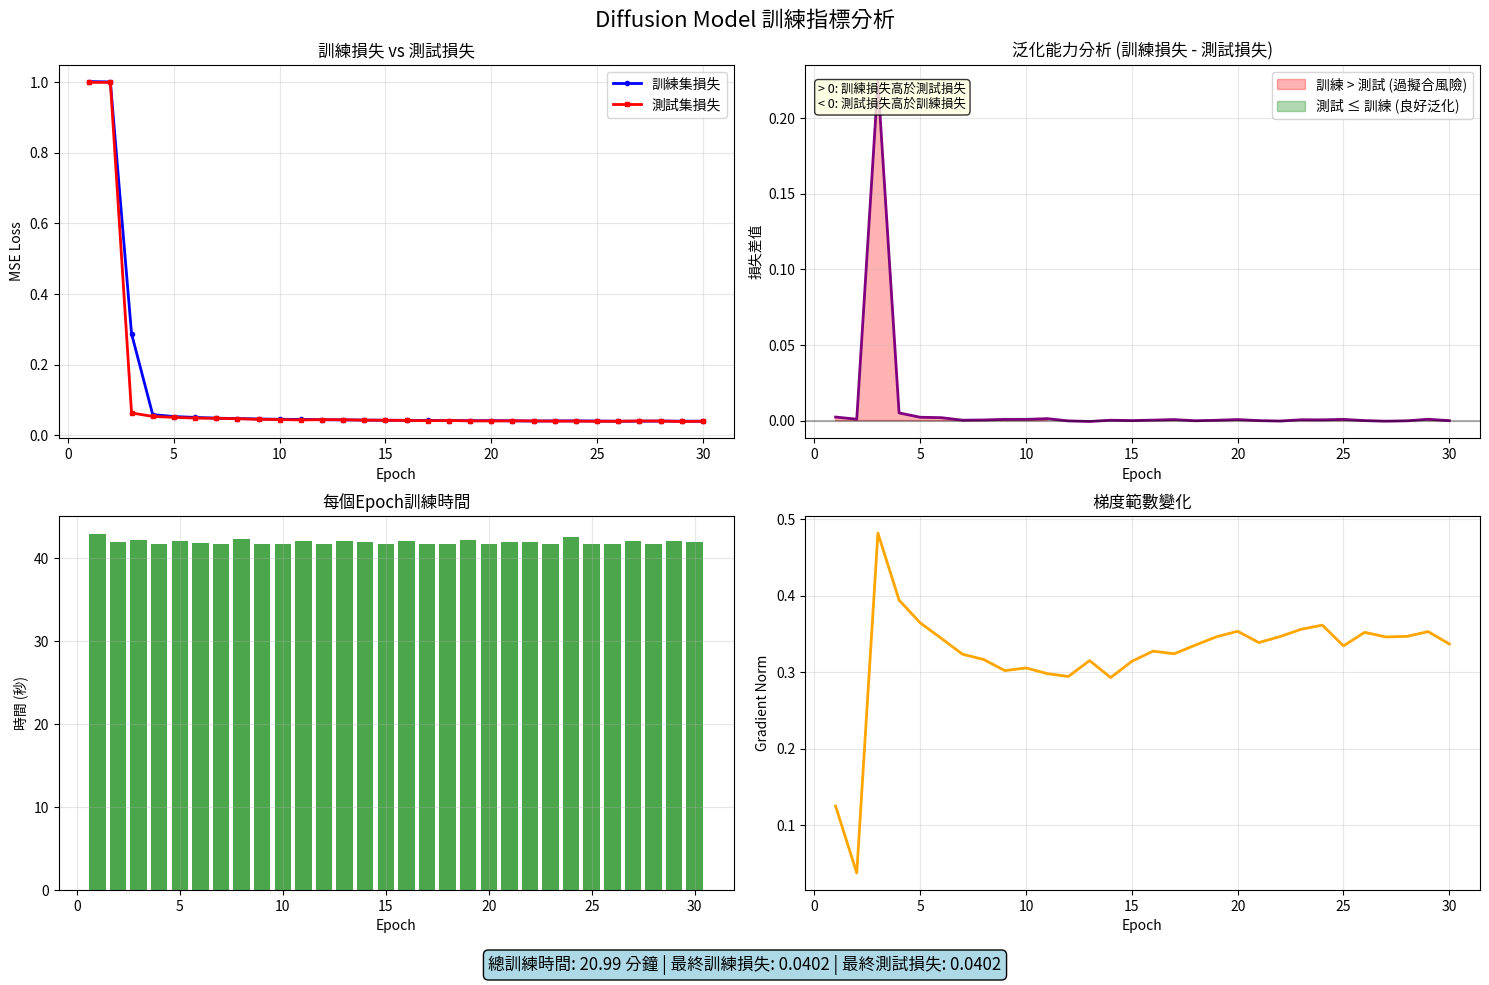

Ê®°ÂûãÂ∑≤ÂÑ≤Â≠òÁÇ∫ 'mnist_diffusion_model.pth'


In [ ]:
# ÂÆåÊï¥ÁöÑMNIST DiffusionÂØ¶È©ó
if __name__ == "__main__":
    # Ë®≠ÂÆöÂèÉÊï∏
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"‰ΩøÁî®Ë£ùÁΩÆ: {device}")

    batch_size = 128  # ÊåâÁÖßÂúñÁâáË¶ÅÊ±Ç

    # 1. ËºâÂÖ•MNISTË≥áÊñôÈõÜ
    print("ËºâÂÖ•MNISTË≥áÊñôÈõÜ...")
    train_dataloader, test_dataloader = get_mnist_dataloaders(batch_size=batch_size)

    # 2. Âª∫Á´ãÊ®°Âûã (MNIST: 1ÈÄöÈÅì, 28x28)
    print("Âª∫Á´ãDiffusion Model...")
    model = DiffusionModel(img_channels=1, img_size=28, timesteps=5000)
    print(f"Ê®°ÂûãÂèÉÊï∏Èáè: {sum(p.numel() for p in model.parameters()):,}")

    # 3. Ë®ìÁ∑¥Ê®°Âûã
    print("ÈñãÂßãË®ìÁ∑¥...")
    diffusion_model, training_metrics = train_diffusion_model(
        model, train_dataloader, test_dataloader, epochs=30, lr=1e-3, device=device
    )

    plot_training_metrics(training_metrics)



    #ÂÑ≤Â≠òÊ®°Âûã
    torch.save(diffusion_model.state_dict(), 'mnist_diffusion_model.pth')
    print("Ê®°ÂûãÂ∑≤ÂÑ≤Â≠òÁÇ∫ 'mnist_diffusion_model.pth'")


ÁîüÊàêÂΩ±ÂÉè...
Ê≠£Âú®ÁîüÊàê 10 ÂºµMNISTÂΩ±ÂÉè...
ÁîüÊàêÂÆåÊàêÔºÅÊé®ÁêÜÊôÇÈñì: 21.79 Áßí
Âπ≥ÂùáÊØèÂºµÂúñÁâá: 2.18 Áßí


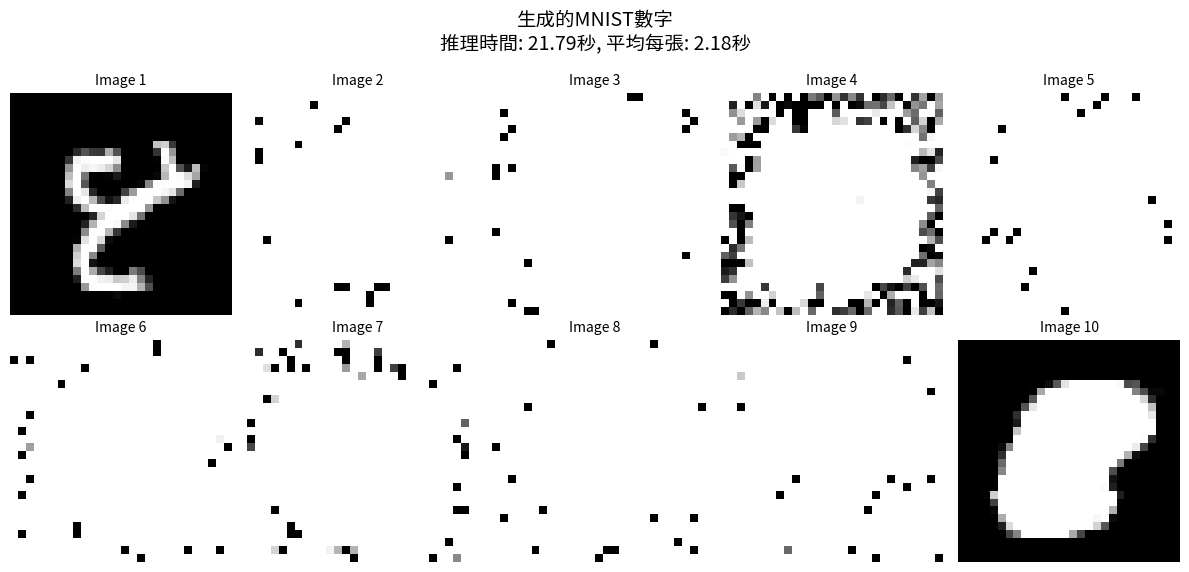

ÊàêÂäüÁîüÊàê 10 ÂºµMNISTÂΩ±ÂÉè
ÂΩ±ÂÉèÂ∞∫ÂØ∏: torch.Size([10, 1, 28, 28])


In [ ]:
print("ÁîüÊàêÂΩ±ÂÉè...")
# üé® ÁîüÊàêÂõæÂÉèÔºàÂ∏¶Êé®ÁêÜÊó∂Èó¥ÁõëÊéßÔºâ
diffusion_model_generated_images, inference_time = generate_mnist_images(
    diffusion_model, num_images=10, device=device
)

# üñºÔ∏è ÂèØËßÜÂåñÔºàÊòæÁ§∫Êé®ÁêÜÊó∂Èó¥Ôºâ
visualize_mnist_images(diffusion_model_generated_images, "ÁîüÊàêÁöÑMNISTÊï∏Â≠ó", inference_time)

print(f"ÊàêÂäüÁîüÊàê {diffusion_model_generated_images.shape[0]} ÂºµMNISTÂΩ±ÂÉè")
print(f"ÂΩ±ÂÉèÂ∞∫ÂØ∏: {diffusion_model_generated_images.shape}")

## GAN

### Ê®°ÂûãË®≠ÂÆö

In [ ]:
"""## GAN (Generative Adversarial Networks)

### Ê®°ÂûãË®≠ÂÆö
"""

class Generator(nn.Module):
    """
    GANÁîüÊàêÂô® - ÂæûÈö®Ê©üÂô™ËÅ≤ÁîüÊàêMNISTÂúñÂÉè
    """
    def __init__(self, noise_dim=100, hidden_dim=256):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim

        self.model = nn.Sequential(
            nn.Linear(noise_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.BatchNorm1d(hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 4, 784),  # 28*28 = 784
            nn.Tanh()  # Ëº∏Âá∫ÁØÑÂúç [-1, 1]
        )

    def forward(self, z):
        """ÁîüÊàêÂô®ÂâçÂêëÂÇ≥Êí≠"""
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)  # ÈáçÂ°ëÁÇ∫ÂúñÂÉèÊ†ºÂºè
        return img


class Discriminator(nn.Module):
    """
    GANÂà§Âà•Âô® - Âà§Êñ∑Ëº∏ÂÖ•ÂúñÂÉèÊòØÁúüÂØ¶ÈÇÑÊòØÁîüÊàêÁöÑ
    """
    def __init__(self, hidden_dim=256):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(784, hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # Ëº∏Âá∫Ê¶ÇÁéá [0, 1]
        )

    def forward(self, img):
        """Âà§Âà•Âô®ÂâçÂêëÂÇ≥Êí≠"""
        img_flat = img.view(img.size(0), -1)  # Â±ïÂπ≥ÂúñÂÉè
        validity = self.model(img_flat)
        return validity


class GAN:
    """GANÊ®°ÂûãÂåÖË£ùÈ°û"""
    def __init__(self, noise_dim=100, hidden_dim=256):
        self.noise_dim = noise_dim
        self.generator = Generator(noise_dim, hidden_dim)
        self.discriminator = Discriminator(hidden_dim)


### Ë®ìÁ∑¥ÂíåÂèØË¶ñÂåñ

In [ ]:
"""### Ë®ìÁ∑¥ÂíåÂèØË¶ñÂåñ"""

def train_gan_model(generator, discriminator, train_dataloader, test_dataloader, epochs=30, lr=2e-4, device='cuda'):
    """
    Ë®ìÁ∑¥GANÊ®°Âûã
    """
    # Ë®≠ÁΩÆË®ìÁ∑¥seed
    torch.manual_seed(42)
    if device == 'cuda':
        torch.cuda.manual_seed(42)
        torch.cuda.manual_seed_all(42)
    np.random.seed(42)

    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    adversarial_loss = nn.BCELoss()

    generator.to(device)
    discriminator.to(device)

    # Ë®ìÁ∑¥Áõ£ÊéßÊåáÊ®ô
    training_metrics = {
        'generator_losses': [],
        'discriminator_losses': [],
        'real_acc': [],      # Âà§Âà•Âô®Â∞çÁúüÂØ¶ÂúñÂÉèÁöÑÊ∫ñÁ¢∫Áéá
        'fake_acc': [],      # Âà§Âà•Âô®Â∞çÁîüÊàêÂúñÂÉèÁöÑÊ∫ñÁ¢∫Áéá
        'epoch_times': [],
        'total_training_time': 0
    }

    print("ÈñãÂßãË®ìÁ∑¥MNIST GANÊ®°Âûã...")
    print(f"ÁîüÊàêÂô®ÂèÉÊï∏Èáè: {sum(p.numel() for p in generator.parameters()):,}")
    print(f"Âà§Âà•Âô®ÂèÉÊï∏Èáè: {sum(p.numel() for p in discriminator.parameters()):,}")
    print("=" * 60)

    total_start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()

        generator.train()
        discriminator.train()

        epoch_g_loss = 0
        epoch_d_loss = 0
        epoch_real_acc = 0
        epoch_fake_acc = 0
        num_batches = len(train_dataloader)

        for batch_idx, (real_imgs, _) in enumerate(train_dataloader):
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device)

            # ÁúüÂØ¶ÂíåÂÅáÊ®ôÁ±§
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # ============ Ë®ìÁ∑¥Âà§Âà•Âô® ============
            optimizer_D.zero_grad()

            # ÁúüÂØ¶ÂúñÂÉèÁöÑÊêçÂ§±
            real_pred = discriminator(real_imgs)
            d_real_loss = adversarial_loss(real_pred, real_labels)

            # ÁîüÊàêÂúñÂÉèÁöÑÊêçÂ§±
            noise = torch.randn(batch_size, generator.noise_dim).to(device)
            fake_imgs = generator(noise)
            fake_pred = discriminator(fake_imgs.detach())
            d_fake_loss = adversarial_loss(fake_pred, fake_labels)

            # Á∏ΩÂà§Âà•Âô®ÊêçÂ§±
            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            # ============ Ë®ìÁ∑¥ÁîüÊàêÂô® ============
            optimizer_G.zero_grad()

            # ÁîüÊàêÂô®Â∏åÊúõÂà§Âà•Âô®Â∞áÁîüÊàêÂúñÂÉèÂà§Êñ∑ÁÇ∫ÁúüÂØ¶
            fake_pred = discriminator(fake_imgs)
            g_loss = adversarial_loss(fake_pred, real_labels)

            g_loss.backward()
            optimizer_G.step()

            # Ë®òÈåÑÊåáÊ®ô
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()

            # Ë®àÁÆóÊ∫ñÁ¢∫Áéá
            real_acc = (real_pred > 0.5).float().mean().item()
            fake_acc = (fake_pred <= 0.5).float().mean().item()
            epoch_real_acc += real_acc
            epoch_fake_acc += fake_acc

            # ÊØè200ÂÄãÊâπÊ¨°È°ØÁ§∫ÈÄ≤Â∫¶
            if epoch % 10 == 0 and batch_idx % 200 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}/{num_batches}], '
                      f'G Loss: {g_loss.item():.4f}, D Loss: {d_loss.item():.4f}, '
                      f'Real Acc: {real_acc:.4f}, Fake Acc: {fake_acc:.4f}')

        # Ë®òÈåÑepochÊåáÊ®ô
        epoch_time = time.time() - epoch_start_time
        avg_g_loss = epoch_g_loss / num_batches
        avg_d_loss = epoch_d_loss / num_batches
        avg_real_acc = epoch_real_acc / num_batches
        avg_fake_acc = epoch_fake_acc / num_batches

        training_metrics['generator_losses'].append(avg_g_loss)
        training_metrics['discriminator_losses'].append(avg_d_loss)
        training_metrics['real_acc'].append(avg_real_acc)
        training_metrics['fake_acc'].append(avg_fake_acc)
        training_metrics['epoch_times'].append(epoch_time)

        print(f'Epoch [{epoch+1}/{epochs}] - GÊêçÂ§±: {avg_g_loss:.4f}, '
              f'DÊêçÂ§±: {avg_d_loss:.4f}, ÁúüÂØ¶Ê∫ñÁ¢∫Áéá: {avg_real_acc:.4f}, '
              f'ÂÅáÂúñÊ∫ñÁ¢∫Áéá: {avg_fake_acc:.4f}, Áî®ÊôÇ: {epoch_time:.1f}Áßí')
        print("-" * 60)

    # Á∏ΩË®ìÁ∑¥ÊôÇÈñì
    total_training_time = time.time() - total_start_time
    training_metrics['total_training_time'] = total_training_time

    print("=" * 60)
    print("GANË®ìÁ∑¥ÂÆåÊàêÔºÅ")
    print(f"Á∏ΩË®ìÁ∑¥ÊôÇÈñì: {total_training_time/60:.2f} ÂàÜÈêò")
    print(f"ÊúÄÁµÇÁîüÊàêÂô®ÊêçÂ§±: {training_metrics['generator_losses'][-1]:.4f}")
    print(f"ÊúÄÁµÇÂà§Âà•Âô®ÊêçÂ§±: {training_metrics['discriminator_losses'][-1]:.4f}")
    print("=" * 60)

    return generator, discriminator, training_metrics


def generate_gan_images(generator, num_images=10, device='cuda'):
    """
    ‰ΩøÁî®GANÁîüÊàêMNISTÂúñÂÉè - ÁßªÈô§seedË®≠ÁΩÆ
    """
    generator.eval()
    inference_start_time = time.time()

    with torch.no_grad():
        # ÁßªÈô§ torch.manual_seed(42)

        print(f"Ê≠£Âú®ÁîüÊàê {num_images} ÂºµMNISTÂúñÂÉè...")
        noise = torch.randn(num_images, generator.noise_dim).to(device)
        generated_images = generator(noise)
        generated_images = (generated_images + 1) / 2
        generated_images = torch.clamp(generated_images, 0, 1)

    inference_time = time.time() - inference_start_time
    print(f"GANÁîüÊàêÂÆåÊàêÔºÅÊé®ÁêÜÊôÇÈñì: {inference_time:.4f} Áßí")
    print(f"Âπ≥ÂùáÊØèÂºµÂúñÁâá: {inference_time/num_images:.4f} Áßí")
    return generated_images, inference_time


def plot_gan_training_metrics(training_metrics):
    """
    Áπ™Ë£ΩGANË®ìÁ∑¥ÊåáÊ®ô
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('GAN Ë®ìÁ∑¥ÊåáÊ®ôÂàÜÊûê', fontsize=16)

    epochs = range(1, len(training_metrics['generator_losses'])+1)

    # 1. ÁîüÊàêÂô®ÂíåÂà§Âà•Âô®ÊêçÂ§±
    axes[0, 0].plot(epochs, training_metrics['generator_losses'], 'b-',
                    linewidth=2, label='ÁîüÊàêÂô®ÊêçÂ§±', marker='o', markersize=3)
    axes[0, 0].plot(epochs, training_metrics['discriminator_losses'], 'r-',
                    linewidth=2, label='Âà§Âà•Âô®ÊêçÂ§±', marker='s', markersize=3)
    axes[0, 0].set_title('ÁîüÊàêÂô® vs Âà§Âà•Âô®ÊêçÂ§±')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Âà§Âà•Âô®Ê∫ñÁ¢∫Áéá
    axes[0, 1].plot(epochs, training_metrics['real_acc'], 'g-',
                    linewidth=2, label='ÁúüÂØ¶ÂúñÂÉèÊ∫ñÁ¢∫Áéá', marker='o', markersize=3)
    axes[0, 1].plot(epochs, training_metrics['fake_acc'], 'm-',
                    linewidth=2, label='ÂÅáÂúñÂÉèÊ∫ñÁ¢∫Áéá', marker='s', markersize=3)
    axes[0, 1].axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='Èö®Ê©üÁåúÊ∏¨')
    axes[0, 1].set_title('Âà§Âà•Âô®Ê∫ñÁ¢∫Áéá')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. ÊØèÂÄãepochË®ìÁ∑¥ÊôÇÈñì
    axes[1, 0].bar(epochs, training_metrics['epoch_times'], alpha=0.7, color='orange')
    axes[1, 0].set_title('ÊØèÂÄãEpochË®ìÁ∑¥ÊôÇÈñì')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('ÊôÇÈñì (Áßí)')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. ÊêçÂ§±Âπ≥Ë°°ÂàÜÊûê
    loss_balance = [g/d if d != 0 else 0 for g, d in zip(training_metrics['generator_losses'],
                                                          training_metrics['discriminator_losses'])]
    axes[1, 1].plot(epochs, loss_balance, 'purple', linewidth=2)
    axes[1, 1].axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Âπ≥Ë°°Èªû')
    axes[1, 1].set_title('ÊêçÂ§±Âπ≥Ë°° (G_loss / D_loss)')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('ÊØîÂÄº')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Ê∑ªÂä†Á∏ΩÁµêË≥áË®ä
    final_g_loss = training_metrics['generator_losses'][-1]
    final_d_loss = training_metrics['discriminator_losses'][-1]
    total_time_text = (f"Á∏ΩË®ìÁ∑¥ÊôÇÈñì: {training_metrics['total_training_time']/60:.2f} ÂàÜÈêò | "
                      f"ÊúÄÁµÇGÊêçÂ§±: {final_g_loss:.4f} | ÊúÄÁµÇDÊêçÂ§±: {final_d_loss:.4f}")
    fig.text(0.5, 0.02, total_time_text, ha='center', fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()

### ‰∏ªÁ®ãÂºèÂíåÊàêÊûú

‰ΩøÁî®Ë®≠ÂÇô: cuda
ËºâÂÖ•MNISTË≥áÊñô...
ÂâµÂª∫GANÊ®°Âûã...
GANÁîüÊàêÂô®ÂèÉÊï∏Èáè: 1,489,424
GANÂà§Âà•Âô®ÂèÉÊï∏Èáè: 1,460,225
Ë®ìÁ∑¥GAN...
ÈñãÂßãË®ìÁ∑¥MNIST GANÊ®°Âûã...
ÁîüÊàêÂô®ÂèÉÊï∏Èáè: 1,489,424
Âà§Âà•Âô®ÂèÉÊï∏Èáè: 1,460,225
Epoch [1/30], Batch [0/469], G Loss: 0.6686, D Loss: 0.6768, Real Acc: 0.9844, Fake Acc: 0.0234
Epoch [1/30], Batch [200/469], G Loss: 0.7911, D Loss: 0.5987, Real Acc: 0.5781, Fake Acc: 0.7188
Epoch [1/30], Batch [400/469], G Loss: 1.8570, D Loss: 0.5696, Real Acc: 0.9609, Fake Acc: 1.0000
Epoch [1/30] - GÊêçÂ§±: 1.0217, DÊêçÂ§±: 0.6181, ÁúüÂØ¶Ê∫ñÁ¢∫Áéá: 0.7646, ÂÅáÂúñÊ∫ñÁ¢∫Áéá: 0.7966, Áî®ÊôÇ: 13.6Áßí
------------------------------------------------------------
Epoch [2/30] - GÊêçÂ§±: 1.1284, DÊêçÂ§±: 0.5826, ÁúüÂØ¶Ê∫ñÁ¢∫Áéá: 0.7123, ÂÅáÂúñÊ∫ñÁ¢∫Áéá: 0.8160, Áî®ÊôÇ: 14.0Áßí
------------------------------------------------------------
Epoch [3/30] - GÊêçÂ§±: 1.1954, DÊêçÂ§±: 0.5589, ÁúüÂØ¶Ê∫ñÁ¢∫Áéá: 0.7020, ÂÅáÂúñÊ∫ñÁ¢∫Áéá: 0.8184, Áî®ÊôÇ: 13.9Áßí
------------

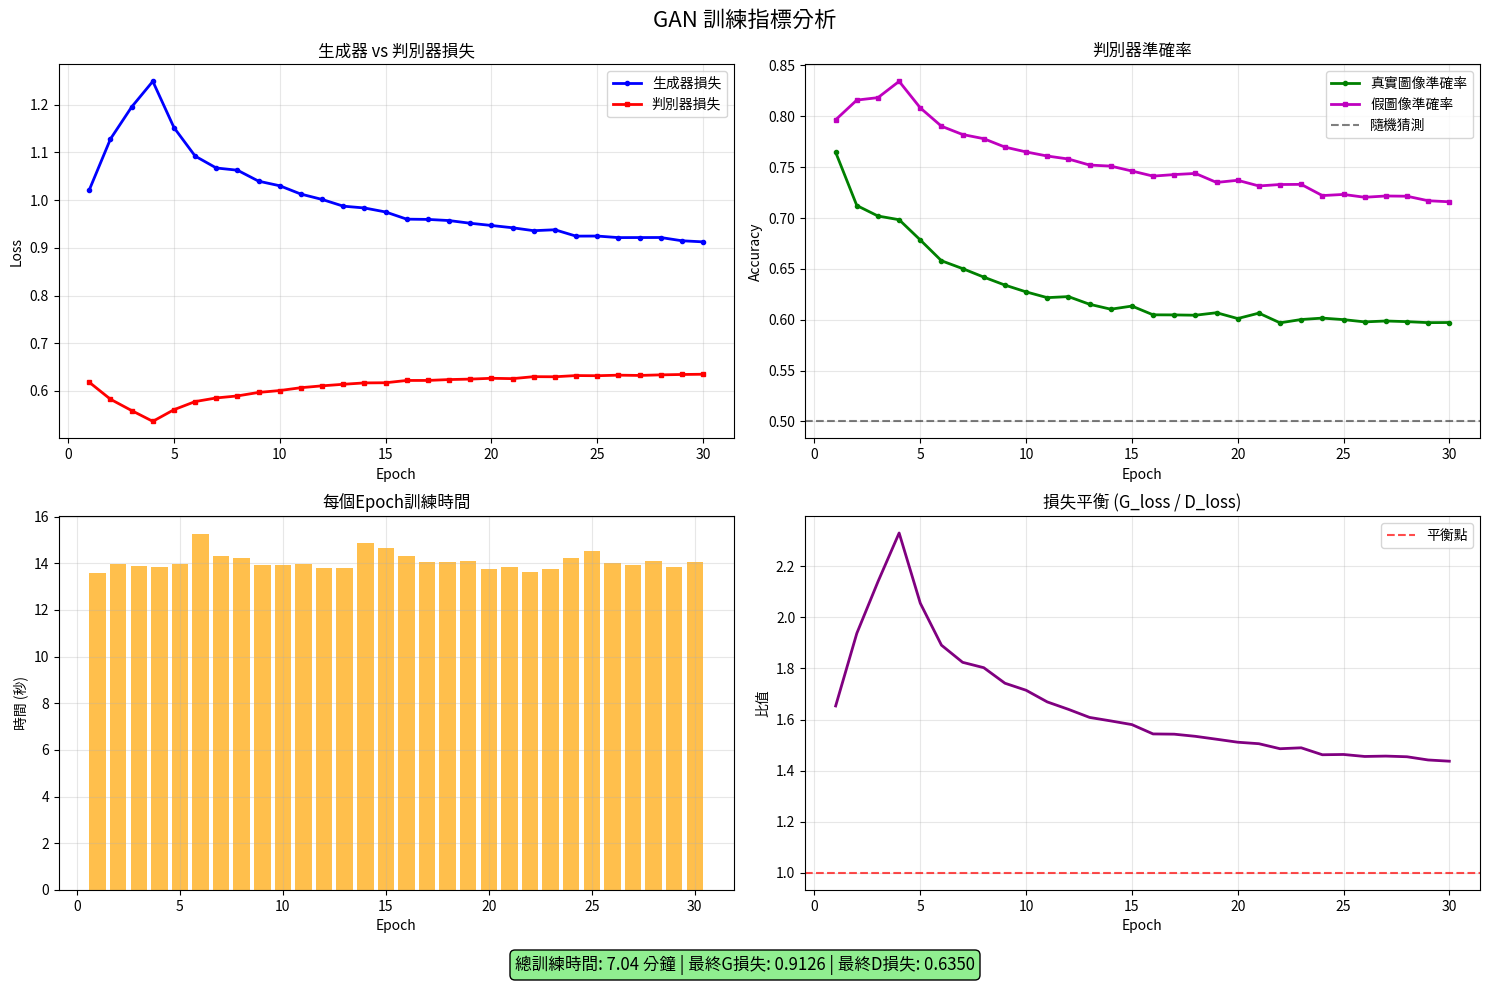

In [ ]:
"""### ‰∏ªÁ®ãÂºèÂíåÁµêÊûú"""

# GAN ‰∏ªÁ®ãÂºè
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"‰ΩøÁî®Ë®≠ÂÇô: {device}")

# 1. ËºâÂÖ•MNISTË≥áÊñô (‰ΩøÁî®ËàáVAEÁõ∏ÂêåÁöÑdataloader)
print("ËºâÂÖ•MNISTË≥áÊñô...")
# train_dataloader, test_dataloader Â∑≤Á∂ìÂú®ÂâçÈù¢ËºâÂÖ•ÈÅé‰∫Ü

# 2. ÂâµÂª∫GANÊ®°Âûã
print("ÂâµÂª∫GANÊ®°Âûã...")
gan_model = GAN(noise_dim=100, hidden_dim=256)
generator = gan_model.generator
discriminator = gan_model.discriminator
print(f"GANÁîüÊàêÂô®ÂèÉÊï∏Èáè: {sum(p.numel() for p in generator.parameters()):,}")
print(f"GANÂà§Âà•Âô®ÂèÉÊï∏Èáè: {sum(p.numel() for p in discriminator.parameters()):,}")

# 3. Ë®ìÁ∑¥GANÊ®°Âûã
print("Ë®ìÁ∑¥GAN...")
trained_generator, trained_discriminator, gan_training_metrics = train_gan_model(
    generator,
    discriminator,
    train_dataloader,
    test_dataloader,
    epochs=30,
    lr=2e-4,
    device=device
)

# 4. Áπ™Ë£ΩGANË®ìÁ∑¥ÊåáÊ®ô
plot_gan_training_metrics(gan_training_metrics)

ÁîüÊàêGANÂúñÂÉè...
Ê≠£Âú®ÁîüÊàê 10 ÂºµMNISTÂúñÂÉè...
GANÁîüÊàêÂÆåÊàêÔºÅÊé®ÁêÜÊôÇÈñì: 0.0044 Áßí
Âπ≥ÂùáÊØèÂºµÂúñÁâá: 0.0004 Áßí


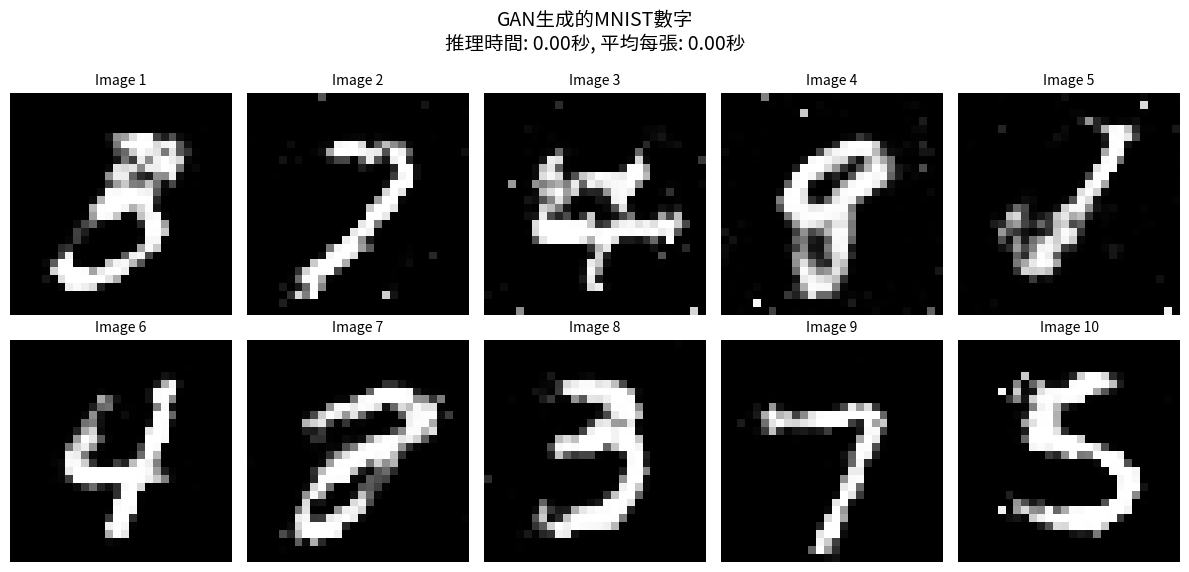

GANÊ®°ÂûãÂ∑≤‰øùÂ≠òÁÇ∫ 'mnist_gan_generator.pth' Âíå 'mnist_gan_discriminator.pth'


In [ ]:
# 5. ÁîüÊàêGANÂúñÂÉè
print("ÁîüÊàêGANÂúñÂÉè...")
gan_generated_images, gan_inference_time = generate_gan_images(
    trained_generator, num_images=10, device=device
)

# 6. ÂèØË¶ñÂåñGANÁµêÊûú
visualize_mnist_images(gan_generated_images, "GANÁîüÊàêÁöÑMNISTÊï∏Â≠ó", gan_inference_time)

# 7. ‰øùÂ≠òGANÊ®°Âûã
torch.save(trained_generator.state_dict(), 'mnist_gan_generator.pth')
torch.save(trained_discriminator.state_dict(), 'mnist_gan_discriminator.pth')
print("GANÊ®°ÂûãÂ∑≤‰øùÂ≠òÁÇ∫ 'mnist_gan_generator.pth' Âíå 'mnist_gan_discriminator.pth'")

print("=" * 80)

##CGAN

### Ê®°ÂûãË®≠ÂÆö

In [ ]:
"""## cGAN (Conditional GAN)

### Ê®°ÂûãË®≠ÂÆö
"""

class ConditionalGenerator(nn.Module):
    """
    cGANÊ¢ù‰ª∂ÁîüÊàêÂô® - Ê†πÊìöÈ°ûÂà•Ê®ôÁ±§ÁîüÊàêMNISTÂúñÂÉè
    """
    def __init__(self, noise_dim=100, num_classes=10, hidden_dim=256):
        super(ConditionalGenerator, self).__init__()
        self.noise_dim = noise_dim
        self.num_classes = num_classes

        # Ê®ôÁ±§ÂµåÂÖ•
        self.label_embedding = nn.Embedding(num_classes, num_classes)

        self.model = nn.Sequential(
            nn.Linear(noise_dim + num_classes, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.BatchNorm1d(hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 4, 784),  # 28*28 = 784
            nn.Tanh()  # Ëº∏Âá∫ÁØÑÂúç [-1, 1]
        )

    def forward(self, noise, labels):
        """Ê¢ù‰ª∂ÁîüÊàêÂô®ÂâçÂêëÂÇ≥Êí≠"""
        # ÂµåÂÖ•Ê®ôÁ±§
        label_embedding = self.label_embedding(labels)

        # ÈÄ£Êé•Âô™ËÅ≤ÂíåÊ®ôÁ±§
        gen_input = torch.cat([noise, label_embedding], dim=1)

        img = self.model(gen_input)
        img = img.view(img.size(0), 1, 28, 28)
        return img


class ConditionalDiscriminator(nn.Module):
    """
    cGANÊ¢ù‰ª∂Âà§Âà•Âô® - Ê†πÊìöÂúñÂÉèÂíåÊ®ôÁ±§Âà§Êñ∑ÁúüÂÅá
    """
    def __init__(self, num_classes=10, hidden_dim=256):
        super(ConditionalDiscriminator, self).__init__()
        self.num_classes = num_classes

        # Ê®ôÁ±§ÂµåÂÖ•
        self.label_embedding = nn.Embedding(num_classes, num_classes)

        self.model = nn.Sequential(
            nn.Linear(784 + num_classes, hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # Ëº∏Âá∫Ê¶ÇÁéá [0, 1]
        )

    def forward(self, img, labels):
        """Ê¢ù‰ª∂Âà§Âà•Âô®ÂâçÂêëÂÇ≥Êí≠"""
        # Â±ïÂπ≥ÂúñÂÉè
        img_flat = img.view(img.size(0), -1)

        # ÂµåÂÖ•Ê®ôÁ±§
        label_embedding = self.label_embedding(labels)

        # ÈÄ£Êé•ÂúñÂÉèÂíåÊ®ôÁ±§
        disc_input = torch.cat([img_flat, label_embedding], dim=1)

        validity = self.model(disc_input)
        return validity


class cGAN:
    """cGANÊ®°ÂûãÂåÖË£ùÈ°û"""
    def __init__(self, noise_dim=100, num_classes=10, hidden_dim=256):
        self.noise_dim = noise_dim
        self.num_classes = num_classes
        self.generator = ConditionalGenerator(noise_dim, num_classes, hidden_dim)
        self.discriminator = ConditionalDiscriminator(num_classes, hidden_dim)



### Ë®ìÁ∑¥ÂíåÂèØË¶ñÂåñ

In [ ]:
"""### Ë®ìÁ∑¥ÂíåÂèØË¶ñÂåñ"""

def train_cgan_model(generator, discriminator, train_dataloader, test_dataloader, epochs=30, lr=2e-4, device='cuda'):
    """
    Ë®ìÁ∑¥cGANÊ®°Âûã
    """
    # Ë®≠ÁΩÆË®ìÁ∑¥seed
    torch.manual_seed(42)
    if device == 'cuda':
        torch.cuda.manual_seed(42)
        torch.cuda.manual_seed_all(42)
    np.random.seed(42)

    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    adversarial_loss = nn.BCELoss()

    generator.to(device)
    discriminator.to(device)

    # Ë®ìÁ∑¥Áõ£ÊéßÊåáÊ®ô
    training_metrics = {
        'generator_losses': [],
        'discriminator_losses': [],
        'real_acc': [],
        'fake_acc': [],
        'epoch_times': [],
        'total_training_time': 0
    }

    print("ÈñãÂßãË®ìÁ∑¥MNIST cGANÊ®°Âûã...")
    print(f"Ê¢ù‰ª∂ÁîüÊàêÂô®ÂèÉÊï∏Èáè: {sum(p.numel() for p in generator.parameters()):,}")
    print(f"Ê¢ù‰ª∂Âà§Âà•Âô®ÂèÉÊï∏Èáè: {sum(p.numel() for p in discriminator.parameters()):,}")
    print("=" * 60)

    total_start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()

        generator.train()
        discriminator.train()

        epoch_g_loss = 0
        epoch_d_loss = 0
        epoch_real_acc = 0
        epoch_fake_acc = 0
        num_batches = len(train_dataloader)

        for batch_idx, (real_imgs, real_labels) in enumerate(train_dataloader):
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device)
            real_labels = real_labels.to(device)

            # Label smoothing for discriminator
            real_validity = torch.ones(batch_size, 1).to(device) * 0.9  # 0.9 instead of 1.0
            fake_validity = torch.zeros(batch_size, 1).to(device)

            # ============ Ë®ìÁ∑¥Âà§Âà•Âô® ============
            optimizer_D.zero_grad()

            # ÁúüÂØ¶ÂúñÂÉèÁöÑÊêçÂ§±
            real_pred = discriminator(real_imgs, real_labels)
            d_real_loss = adversarial_loss(real_pred, real_validity)

            # ÁîüÊàêÂÅáÂúñÂÉè
            noise = torch.randn(batch_size, generator.noise_dim).to(device)
            fake_labels = torch.randint(0, generator.num_classes, (batch_size,)).to(device)
            fake_imgs = generator(noise, fake_labels)

            # ÂÅáÂúñÂÉèÁöÑÊêçÂ§±
            fake_pred = discriminator(fake_imgs.detach(), fake_labels)
            d_fake_loss = adversarial_loss(fake_pred, fake_validity)

            # Á∏ΩÂà§Âà•Âô®ÊêçÂ§±
            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            # ============ Ë®ìÁ∑¥ÁîüÊàêÂô® ============
            optimizer_G.zero_grad()

            # ÁîüÊàêÂô®Â∏åÊúõÂà§Âà•Âô®Â∞áÁîüÊàêÂúñÂÉèÂà§Êñ∑ÁÇ∫ÁúüÂØ¶
            fake_pred = discriminator(fake_imgs, fake_labels)
            g_loss = adversarial_loss(fake_pred, torch.ones(batch_size, 1).to(device))

            g_loss.backward()
            optimizer_G.step()

            # Ë®òÈåÑÊåáÊ®ô
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()

            # Ë®àÁÆóÊ∫ñÁ¢∫Áéá
            real_acc = (real_pred > 0.5).float().mean().item()
            fake_acc = (fake_pred <= 0.5).float().mean().item()
            epoch_real_acc += real_acc
            epoch_fake_acc += fake_acc

            # ÊØè200ÂÄãÊâπÊ¨°È°ØÁ§∫ÈÄ≤Â∫¶
            if epoch % 10 == 0 and batch_idx % 200 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}/{num_batches}], '
                      f'G Loss: {g_loss.item():.4f}, D Loss: {d_loss.item():.4f}, '
                      f'Real Acc: {real_acc:.4f}, Fake Acc: {fake_acc:.4f}')

        # Ë®òÈåÑepochÊåáÊ®ô
        epoch_time = time.time() - epoch_start_time
        avg_g_loss = epoch_g_loss / num_batches
        avg_d_loss = epoch_d_loss / num_batches
        avg_real_acc = epoch_real_acc / num_batches
        avg_fake_acc = epoch_fake_acc / num_batches

        training_metrics['generator_losses'].append(avg_g_loss)
        training_metrics['discriminator_losses'].append(avg_d_loss)
        training_metrics['real_acc'].append(avg_real_acc)
        training_metrics['fake_acc'].append(avg_fake_acc)
        training_metrics['epoch_times'].append(epoch_time)

        print(f'Epoch [{epoch+1}/{epochs}] - GÊêçÂ§±: {avg_g_loss:.4f}, '
              f'DÊêçÂ§±: {avg_d_loss:.4f}, ÁúüÂØ¶Ê∫ñÁ¢∫Áéá: {avg_real_acc:.4f}, '
              f'ÂÅáÂúñÊ∫ñÁ¢∫Áéá: {avg_fake_acc:.4f}, Áî®ÊôÇ: {epoch_time:.1f}Áßí')
        print("-" * 60)

    # Á∏ΩË®ìÁ∑¥ÊôÇÈñì
    total_training_time = time.time() - total_start_time
    training_metrics['total_training_time'] = total_training_time

    print("=" * 60)
    print("cGANË®ìÁ∑¥ÂÆåÊàêÔºÅ")
    print(f"Á∏ΩË®ìÁ∑¥ÊôÇÈñì: {total_training_time/60:.2f} ÂàÜÈêò")
    print(f"ÊúÄÁµÇÁîüÊàêÂô®ÊêçÂ§±: {training_metrics['generator_losses'][-1]:.4f}")
    print(f"ÊúÄÁµÇÂà§Âà•Âô®ÊêçÂ§±: {training_metrics['discriminator_losses'][-1]:.4f}")
    print("=" * 60)

    return generator, discriminator, training_metrics


def generate_cgan_images(generator, num_classes=10, samples_per_class=10, device='cuda'):
    """
    ‰ΩøÁî®cGANÁîüÊàêÊåáÂÆöÈ°ûÂà•ÁöÑMNISTÂúñÂÉè - ÁßªÈô§seedË®≠ÁΩÆ
    """
    generator.eval()
    inference_start_time = time.time()

    with torch.no_grad():
        # ÁßªÈô§ torch.manual_seed(42)

        print(f"Ê≠£Âú®ÁîüÊàê {num_classes} ÂÄãÈ°ûÂà•ÔºåÊØèÈ°û {samples_per_class} ÂºµÂúñÂÉè...")
        all_images = []
        all_labels = []

        for class_label in range(num_classes):
            noise = torch.randn(samples_per_class, generator.noise_dim).to(device)
            labels = torch.full((samples_per_class,), class_label, dtype=torch.long).to(device)
            generated_images = generator(noise, labels)
            all_images.append(generated_images)
            all_labels.extend([class_label] * samples_per_class)

        all_images = torch.cat(all_images, dim=0)
        all_images = (all_images + 1) / 2
        all_images = torch.clamp(all_images, 0, 1)

    inference_time = time.time() - inference_start_time
    print(f"cGANÁîüÊàêÂÆåÊàêÔºÅÊé®ÁêÜÊôÇÈñì: {inference_time:.4f} Áßí")
    print(f"Âπ≥ÂùáÊØèÂºµÂúñÁâá: {inference_time/(num_classes*samples_per_class):.4f} Áßí")
    return all_images, all_labels, inference_time



def visualize_cgan_images(images, labels, title="cGANÁîüÊàêÁöÑMNISTÊï∏Â≠ó", inference_time=None):
    """
    ÂèØË¶ñÂåñcGANÁîüÊàêÁöÑÂúñÂÉè - 10x10Ê†ºÂºè
    """
    fig, axes = plt.subplots(10, 10, figsize=(12, 12))

    # Ê®ôÈ°å‰∏≠Âä†ÂÖ•Êé®ÁêÜÊôÇÈñìË≥áË®ä
    if inference_time is not None:
        full_title = f"{title}\nÊé®ÁêÜÊôÇÈñì: {inference_time:.4f}Áßí, Âπ≥ÂùáÊØèÂºµ: {inference_time/len(images):.4f}Áßí"
    else:
        full_title = title

    fig.suptitle(full_title, fontsize=14)

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            img = images[i].squeeze().cpu().numpy()
            ax.imshow(img, cmap='gray')
            ax.set_title(f'Êï∏Â≠ó {labels[i]}', fontsize=8)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


def plot_cgan_training_metrics(training_metrics):
    """
    Áπ™Ë£ΩcGANË®ìÁ∑¥ÊåáÊ®ô
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('cGAN Ë®ìÁ∑¥ÊåáÊ®ôÂàÜÊûê', fontsize=16)

    epochs = range(1, len(training_metrics['generator_losses'])+1)

    # 1. ÁîüÊàêÂô®ÂíåÂà§Âà•Âô®ÊêçÂ§±
    axes[0, 0].plot(epochs, training_metrics['generator_losses'], 'b-',
                    linewidth=2, label='ÁîüÊàêÂô®ÊêçÂ§±', marker='o', markersize=3)
    axes[0, 0].plot(epochs, training_metrics['discriminator_losses'], 'r-',
                    linewidth=2, label='Âà§Âà•Âô®ÊêçÂ§±', marker='s', markersize=3)
    axes[0, 0].set_title('ÁîüÊàêÂô® vs Âà§Âà•Âô®ÊêçÂ§±')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Âà§Âà•Âô®Ê∫ñÁ¢∫Áéá
    axes[0, 1].plot(epochs, training_metrics['real_acc'], 'g-',
                    linewidth=2, label='ÁúüÂØ¶ÂúñÂÉèÊ∫ñÁ¢∫Áéá', marker='o', markersize=3)
    axes[0, 1].plot(epochs, training_metrics['fake_acc'], 'm-',
                    linewidth=2, label='ÂÅáÂúñÂÉèÊ∫ñÁ¢∫Áéá', marker='s', markersize=3)
    axes[0, 1].axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='Èö®Ê©üÁåúÊ∏¨')

### ‰∏ªÁ®ãÂºèÂíåÊàêÊûú

In [ ]:
# cGAN ‰∏ªÁ®ãÂºè
print("ÂâµÂª∫cGANÊ®°Âûã...")
cgan_model = cGAN(noise_dim=100, num_classes=10, hidden_dim=256)
cond_generator = cgan_model.generator
cond_discriminator = cgan_model.discriminator
print(f"cGANÁîüÊàêÂô®ÂèÉÊï∏Èáè: {sum(p.numel() for p in cond_generator.parameters()):,}")
print(f"cGANÂà§Âà•Âô®ÂèÉÊï∏Èáè: {sum(p.numel() for p in cond_discriminator.parameters()):,}")

# ÈáçÊñ∞ËºâÂÖ•Ë≥áÊñô (cGANÈúÄË¶ÅÊ®ôÁ±§)
def get_mnist_dataloaders_with_labels(batch_size=128):
    """
    ËºâÂÖ•MNISTË≥áÊñôÈõÜ - ‰øùÁïôÊ®ôÁ±§Áî®ÊñºcGAN
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Ê≠∏‰∏ÄÂåñÂà∞[-1, 1]
    ])

    # Ë®ìÁ∑¥ÈõÜ
    train_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        transform=transform,
        download=True
    )

    # Ê∏¨Ë©¶ÈõÜ
    test_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=False,
        transform=transform,
        download=True
    )

    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    test_dataloader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    return train_dataloader, test_dataloader

train_dataloader_labeled, test_dataloader_labeled = get_mnist_dataloaders_with_labels(batch_size=128)


ÂâµÂª∫cGANÊ®°Âûã...
cGANÁîüÊàêÂô®ÂèÉÊï∏Èáè: 1,492,084
cGANÂà§Âà•Âô®ÂèÉÊï∏Èáè: 1,470,565


Ë®ìÁ∑¥cGAN...
ÈñãÂßãË®ìÁ∑¥MNIST cGANÊ®°Âûã...
Ê¢ù‰ª∂ÁîüÊàêÂô®ÂèÉÊï∏Èáè: 1,492,084
Ê¢ù‰ª∂Âà§Âà•Âô®ÂèÉÊï∏Èáè: 1,470,565
Epoch [1/30], Batch [0/469], G Loss: 0.6892, D Loss: 0.6947, Real Acc: 0.6641, Fake Acc: 0.3438
Epoch [1/30], Batch [200/469], G Loss: 1.2204, D Loss: 0.6590, Real Acc: 1.0000, Fake Acc: 1.0000
Epoch [1/30], Batch [400/469], G Loss: 1.4259, D Loss: 0.5269, Real Acc: 0.8516, Fake Acc: 1.0000
Epoch [1/30] - GÊêçÂ§±: 1.1325, DÊêçÂ§±: 0.6314, ÁúüÂØ¶Ê∫ñÁ¢∫Áéá: 0.6423, ÂÅáÂúñÊ∫ñÁ¢∫Áéá: 0.8932, Áî®ÊôÇ: 15.3Áßí
------------------------------------------------------------
Epoch [2/30] - GÊêçÂ§±: 1.2844, DÊêçÂ§±: 0.5967, ÁúüÂØ¶Ê∫ñÁ¢∫Áéá: 0.6279, ÂÅáÂúñÊ∫ñÁ¢∫Áéá: 0.8681, Áî®ÊôÇ: 15.0Áßí
------------------------------------------------------------
Epoch [3/30] - GÊêçÂ§±: 1.2951, DÊêçÂ§±: 0.5909, ÁúüÂØ¶Ê∫ñÁ¢∫Áéá: 0.6213, ÂÅáÂúñÊ∫ñÁ¢∫Áéá: 0.8611, Áî®ÊôÇ: 14.5Áßí
------------------------------------------------------------
Epoch [4/30] - GÊêçÂ§±: 1.3174, DÊêçÂ§±: 0.5810, ÁúüÂØ¶Ê∫ñÁ¢∫Á

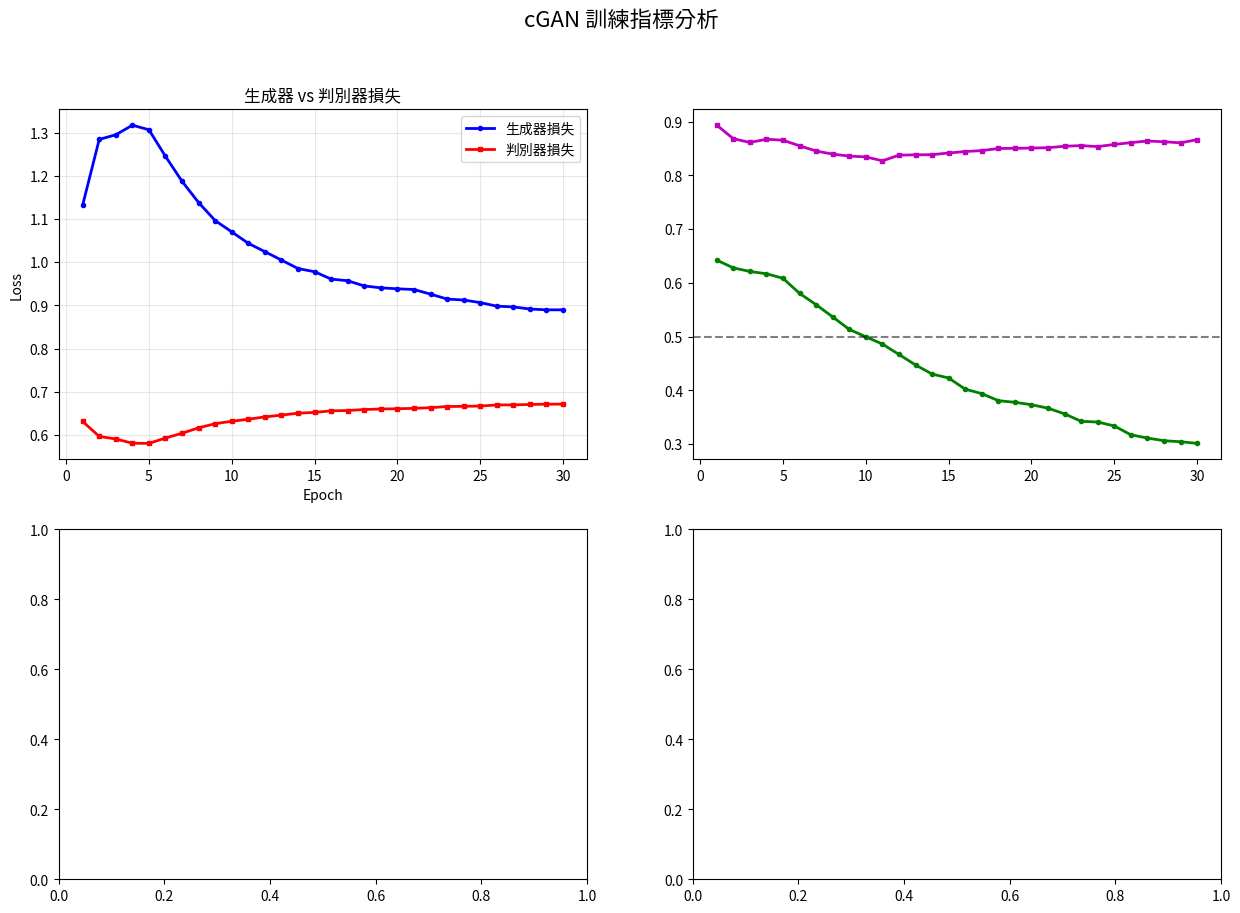

In [ ]:
# 8. Ë®ìÁ∑¥cGANÊ®°Âûã
print("Ë®ìÁ∑¥cGAN...")
trained_cond_generator, trained_cond_discriminator, cgan_training_metrics = train_cgan_model(
    cond_generator,
    cond_discriminator,
    train_dataloader_labeled,
    test_dataloader_labeled,
    epochs=30,
    lr=2e-4,
    device=device
)

# 9. Áπ™Ë£ΩcGANË®ìÁ∑¥ÊåáÊ®ô
plot_cgan_training_metrics(cgan_training_metrics)

ÁîüÊàêcGANÂúñÂÉè...
Ê≠£Âú®ÁîüÊàê 10 ÂÄãÈ°ûÂà•ÔºåÊØèÈ°û 10 ÂºµÂúñÂÉè...
cGANÁîüÊàêÂÆåÊàêÔºÅÊé®ÁêÜÊôÇÈñì: 0.1058 Áßí
Âπ≥ÂùáÊØèÂºµÂúñÁâá: 0.0011 Áßí


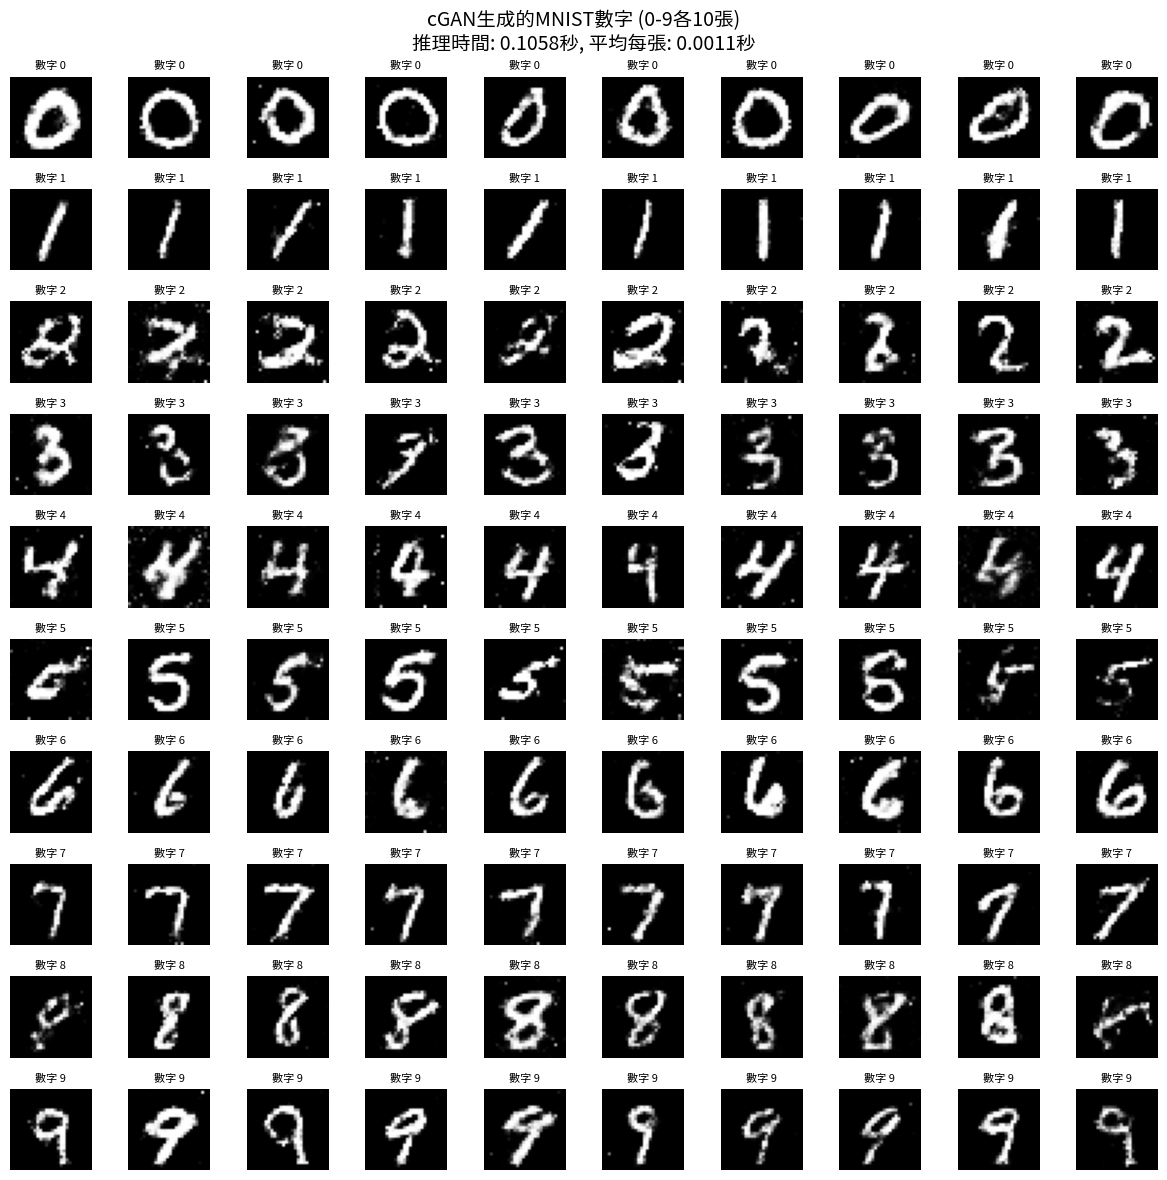

cGANÊ®°ÂûãÂ∑≤‰øùÂ≠òÁÇ∫ 'mnist_cgan_generator.pth' Âíå 'mnist_cgan_discriminator.pth'
ÊâÄÊúâÊ®°ÂûãË®ìÁ∑¥ÂíåÊ∏¨Ë©¶ÂÆåÊàêÔºÅ


In [ ]:
# 10. ÁîüÊàêcGANÂúñÂÉè (ÊØèÂÄãÊï∏Â≠ó10Âºµ)
print("ÁîüÊàêcGANÂúñÂÉè...")
cgan_generated_images, cgan_labels, cgan_inference_time = generate_cgan_images(
    trained_cond_generator, num_classes=10, samples_per_class=10, device=device
)

# 11. ÂèØË¶ñÂåñcGANÁµêÊûú (10x10Ê†ºÂºè)
visualize_cgan_images(cgan_generated_images, cgan_labels, "cGANÁîüÊàêÁöÑMNISTÊï∏Â≠ó (0-9ÂêÑ10Âºµ)", cgan_inference_time)

# 12. ‰øùÂ≠òcGANÊ®°Âûã
torch.save(trained_cond_generator.state_dict(), 'mnist_cgan_generator.pth')
torch.save(trained_cond_discriminator.state_dict(), 'mnist_cgan_discriminator.pth')
print("cGANÊ®°ÂûãÂ∑≤‰øùÂ≠òÁÇ∫ 'mnist_cgan_generator.pth' Âíå 'mnist_cgan_discriminator.pth'")

print("=" * 80)
print("ÊâÄÊúâÊ®°ÂûãË®ìÁ∑¥ÂíåÊ∏¨Ë©¶ÂÆåÊàêÔºÅ")

# ÂõõÁ®ÆÊ®°ÂûãÁîüÊàêÁµêÊûú

ÁîüÊàêVAEÂúñÁâá...
Ê≠£Âú®ÁîüÊàê 10 ÂºµMNISTÂúñÂÉè...
VAEÁîüÊàêÂÆåÊàêÔºÅÊé®ÁêÜÊôÇÈñì: 0.0007 Áßí
Âπ≥ÂùáÊØèÂºµÂúñÁâá: 0.0001 Áßí


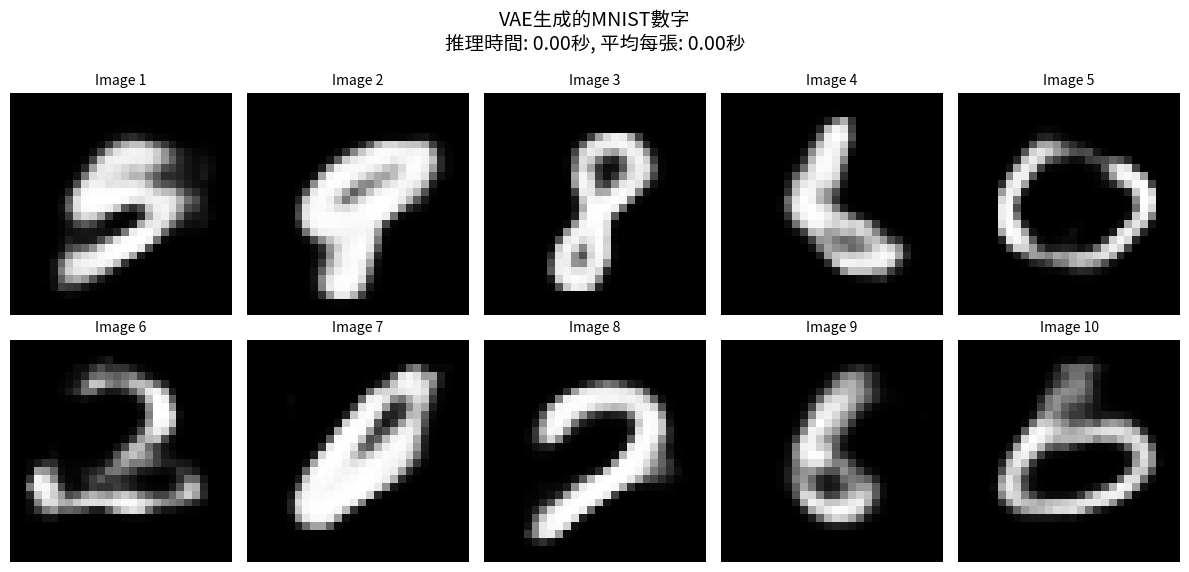

ÁîüÊàêGANÂúñÁâá
Ê≠£Âú®ÁîüÊàê 10 ÂºµMNISTÂúñÂÉè...
GANÁîüÊàêÂÆåÊàêÔºÅÊé®ÁêÜÊôÇÈñì: 0.0020 Áßí
Âπ≥ÂùáÊØèÂºµÂúñÁâá: 0.0002 Áßí


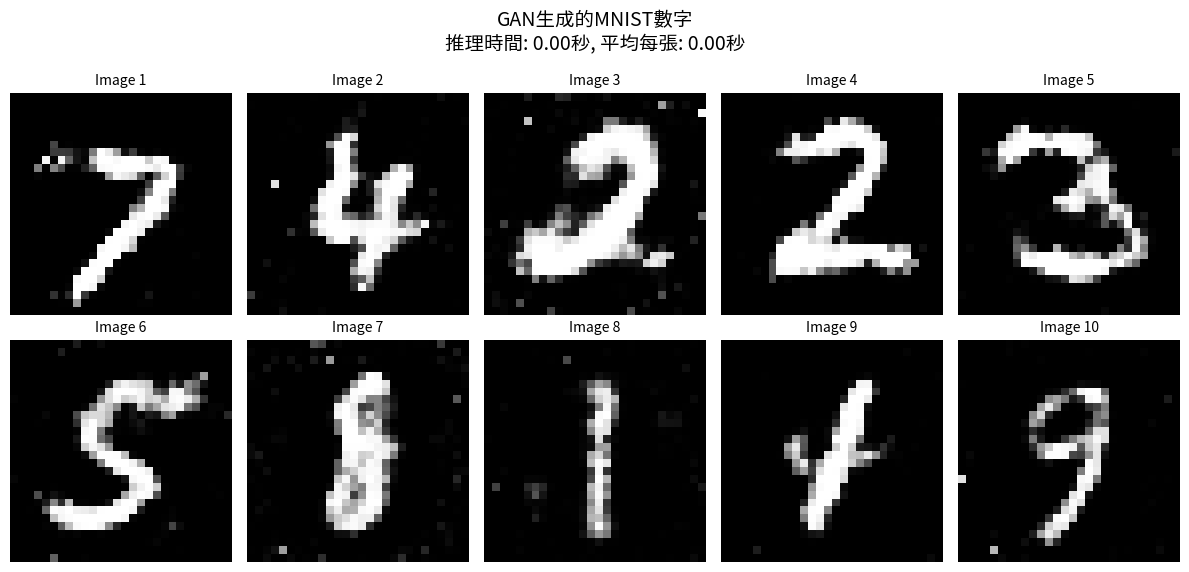

ÁîüÊàêCGANÂúñÁâá
Ê≠£Âú®ÁîüÊàê 10 ÂÄãÈ°ûÂà•ÔºåÊØèÈ°û 10 ÂºµÂúñÂÉè...
cGANÁîüÊàêÂÆåÊàêÔºÅÊé®ÁêÜÊôÇÈñì: 0.0083 Áßí
Âπ≥ÂùáÊØèÂºµÂúñÁâá: 0.0001 Áßí


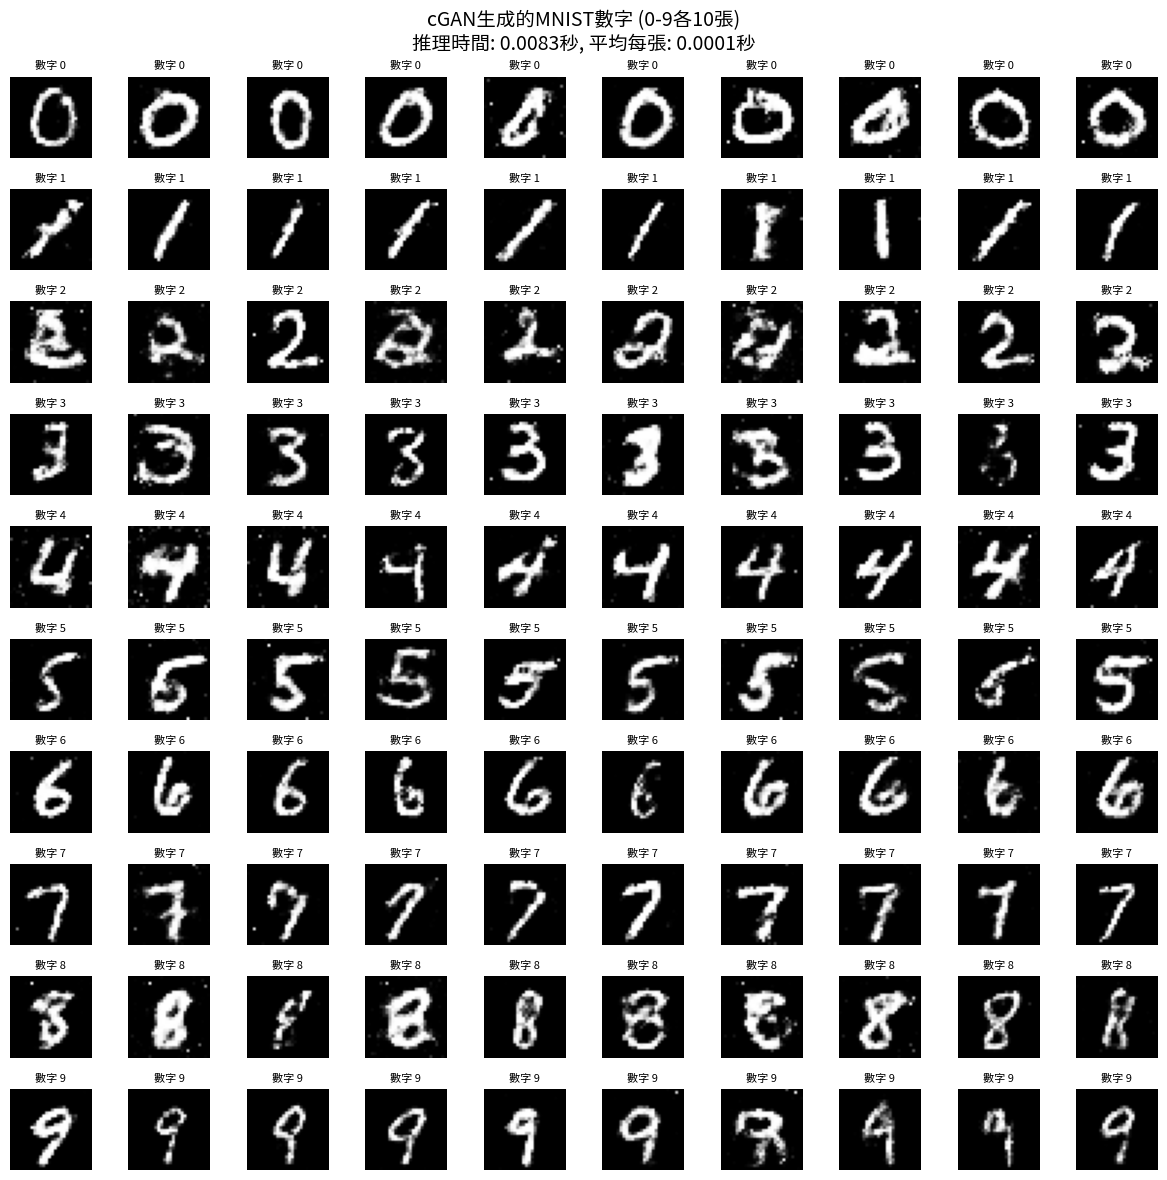

Diffusion modelÁîüÊàêÂΩ±ÂÉè...
Ê≠£Âú®ÁîüÊàê 10 ÂºµMNISTÂΩ±ÂÉè...
ÁîüÊàêÂÆåÊàêÔºÅÊé®ÁêÜÊôÇÈñì: 22.30 Áßí
Âπ≥ÂùáÊØèÂºµÂúñÁâá: 2.23 Áßí


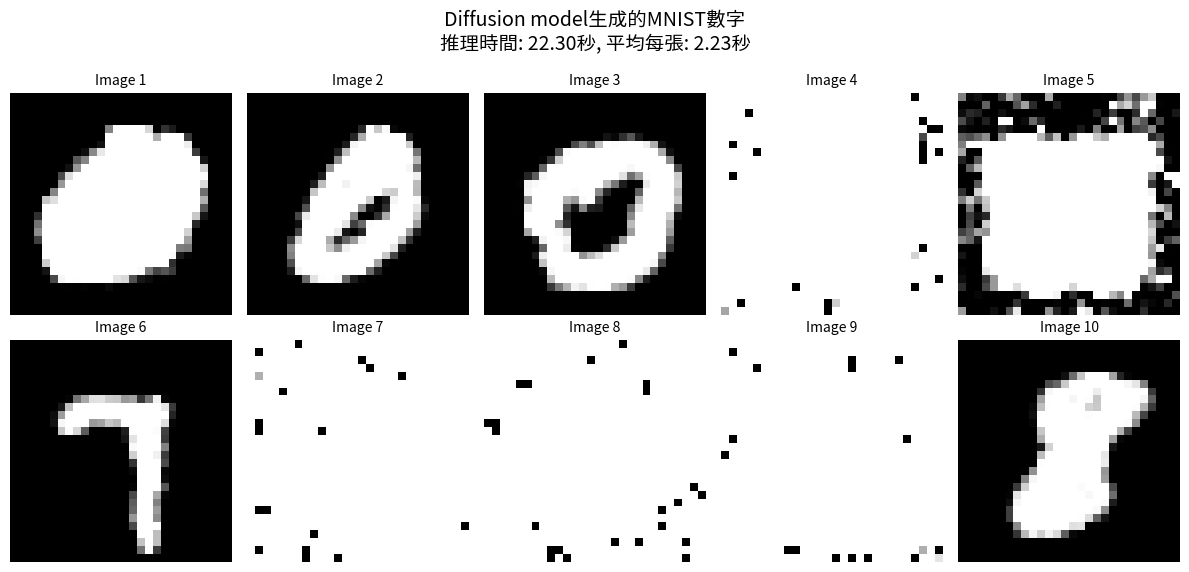

ÊàêÂäüÁîüÊàê 10 ÂºµMNISTÂΩ±ÂÉè
ÂΩ±ÂÉèÂ∞∫ÂØ∏: torch.Size([10, 1, 28, 28])


In [ ]:
#1.VAE
print("ÁîüÊàêVAEÂúñÁâá...")
vae_generated_images, vae_inference_time = generate_vae_images(
    trained_vae_model, num_images=10, device=device
)
visualize_mnist_images(vae_generated_images, "VAEÁîüÊàêÁöÑMNISTÊï∏Â≠ó", vae_inference_time)
#2.GAN
print('ÁîüÊàêGANÂúñÁâá')
gan_generated_images, gan_inference_time = generate_gan_images(
    trained_generator, num_images=10, device=device
)
visualize_mnist_images(gan_generated_images, "GANÁîüÊàêÁöÑMNISTÊï∏Â≠ó", gan_inference_time)

#3.CGAN
print('ÁîüÊàêCGANÂúñÁâá')
cgan_generated_images, cgan_labels, cgan_inference_time = generate_cgan_images(
    trained_cond_generator, num_classes=10, samples_per_class=10, device=device
)
#ÂèØË¶ñÂåñcGANÁµêÊûú (10x10Ê†ºÂºè)
visualize_cgan_images(cgan_generated_images, cgan_labels, "cGANÁîüÊàêÁöÑMNISTÊï∏Â≠ó (0-9ÂêÑ10Âºµ)", cgan_inference_time)

#4.Diffusion model
print("Diffusion modelÁîüÊàêÂΩ±ÂÉè...")
# üé® ÁîüÊàêÂõæÂÉèÔºàÂ∏¶Êé®ÁêÜÊó∂Èó¥ÁõëÊéßÔºâ
diffusion_model_generated_images, inference_time = generate_mnist_images(
    diffusion_model, num_images=10, device=device
)

# üñºÔ∏è ÂèØËßÜÂåñÔºàÊòæÁ§∫Êé®ÁêÜÊó∂Èó¥Ôºâ
visualize_mnist_images(diffusion_model_generated_images, "Diffusion modelÁîüÊàêÁöÑMNISTÊï∏Â≠ó", inference_time)

print(f"ÊàêÂäüÁîüÊàê {diffusion_model_generated_images.shape[0]} ÂºµMNISTÂΩ±ÂÉè")
print(f"ÂΩ±ÂÉèÂ∞∫ÂØ∏: {diffusion_model_generated_images.shape}")